# More Message Passing and Timing Exploration
- Danny Satterthwaite

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.sparse import csgraph
import numpy as np
import time
import pandas as pd
from networkx import barabasi_albert_graph
import heapq

from scipy.stats import rankdata
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


/Users/dannysatterthwaite/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# a sample graph that mirrors the textbook so we can validate the message passing approach

In [2]:

# plot the nodes and their probs
def plot_graph(G, mu_values=None, seed_nodes=None):
    pos = nx.spring_layout(G, seed=42)
    
    if mu_values is not None:
        cmap = plt.cm.viridis
        node_color = [mu_values[node] for node in G.nodes()]
        nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap)
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(mu_values.values()), 
                                                                 vmax=max(mu_values.values())))
        sm.set_array([])
        plt.colorbar(sm, label="mu (Prob NOT in GC)")
        
        if seed_nodes is not None:
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=seed_nodes,
                node_color="none",
                edgecolors="red",
                node_size=800,
                linewidths=2
            )
    else:
        nx.draw(G, pos, with_labels=True)
    
    plt.title("Graph with Node mu-values; Seeds circled in red")
    plt.axis('off')
    plt.show()




def create_cluster_tree_network():
    # Create empty graph
    G = nx.Graph()
    
    # Function to create the red tree structure
    def create_red_tree(num_nodes=50):
        # Start with a central node
        G.add_node(0, color='red')
        
        # Keep track of possible parent nodes
        available_parents = [0]
        
        # Add remaining nodes
        for i in range(1, num_nodes):
            # Select a parent from available parents
            if not available_parents:
                parent = random.randint(0, i-1)
            else:
                parent = random.choice(available_parents)
                
            # Add new node and connect to parent
            G.add_node(i, color='red')
            G.add_edge(parent, i)
            
            # Add this node as a potential parent
            available_parents.append(i)
            
            # Randomly remove some nodes from available parents
            if random.random() < 0.2 and len(available_parents) > 1:
                available_parents.remove(random.choice(available_parents))
    
    # Function to create blue clusters
    def create_blue_clusters(num_large_cluster=3, num_small_clusters=2):
        # Create one large central blue cluster
        center_x, center_y = -3, 0
        node_id = len(G.nodes())
        
        for i in range(num_large_cluster):
            angle = random.random() * 2 * np.pi
            radius = random.random() * 1.5
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            G.add_node(node_id, color='blue', pos=(x, y))
            node_id += 1
        
        # Create several small blue clusters
        for _ in range(num_small_clusters):
            cluster_x = random.uniform(-5, 5)
            cluster_y = random.uniform(-5, 5)
            cluster_size = random.randint(2, 5)
            
            for i in range(cluster_size):
                angle = random.random() * 2 * np.pi
                radius = random.random() * 0.4
                x = cluster_x + radius * np.cos(angle)
                y = cluster_y + radius * np.sin(angle)
                G.add_node(node_id, color='blue', pos=(x, y))
                node_id += 1
    
    # Create the graph structures
    create_red_tree()
    create_blue_clusters()
    
    return G


## plotting function

In [3]:
# Plot the graph with node probabilities
def plot_graph(G, mu_values=None, seed_nodes=None):
    pos = nx.spring_layout(G, seed=42)
    
    if mu_values is not None:
        cmap = plt.cm.viridis
        #node_color = [mu_values[node] for node in G.nodes()]
        node_color = [round(mu_values[node], 2) for node in G.nodes()]
        nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap)
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(mu_values.values()), 
                                                                 vmax=max(mu_values.values())))
        sm.set_array([])
        plt.colorbar(sm, label="μ (Prob NOT in GC)")
        
        if seed_nodes is not None:
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=seed_nodes,
                node_color="none",
                edgecolors="red",
                node_size=800,
                linewidths=2
            )
    else:
        nx.draw(G, pos, with_labels=True)
    
    plt.title("Graph with Node μ-values; Seeds circled in red")
    plt.axis('off')
    plt.show()

# Message passing approach

In [4]:
def compute_not_in_giant_component_probabilities(graph, activation_probabilities, iterations=500, tolerance=1e-6):
    """
    Implements the message passing update equations (4) and (5) from percolation theory,
    computing μ_i and μ_{i<-j} iteratively.

    Args:
        graph (nx.Graph): NetworkX graph
        percolation_probability (float): Bond percolation probability (p)
        iterations (int): Max number of iterations
        tolerance (float): Convergence threshold


    """
    nodes = list(graph.nodes())
    
    # Initialize messages: from j to i 
    #probability j is NOT in the GC when i is removed
    mu_from = {
        (j, i): 0.25 # quite sensitive but 0.3 or .5 seems to work
        for i in nodes
        for j in graph.neighbors(i)
    }

    mu = {i: 0.5 for i in nodes} #marginal probability that node i is not in GC... asssume 50/50 shot of being in the GC
    
    for iter_count in range(iterations):
        previous_mu = mu.copy()
        updated_mu_from = mu_from.copy()

        # Update messages using Eq (5)
        for (j, i) in mu_from:
            product = 1.0
            for k in graph.neighbors(j):
                if k != i:
                    msg = mu_from.get((k, j), 0.5)
                    #percolation-adjusted message: (1 - p + p * μ_{j k})
                    p_jk = activation_probabilities.get((j, k), 0.5)
                    product *= (1 - p_jk + p_jk * msg)
                    #term = 1 - percolation_probability + percolation_probability * msg
                    #product *= term
            # update message
            updated_mu_from[(j, i)] = product

        # Update node marginals using Eq (4)
        for i in nodes:
            product = 1.0
            for j in graph.neighbors(i):
                msg = updated_mu_from.get((j, i), 0.5)
                p_ji = activation_probabilities.get((j, i), 0.5)
                product *= (1 - p_ji + p_ji * msg)
                #percolation-adjusted message for μ_{i}
                #term = 1 - percolation_probability + percolation_probability * msg
                #product *= term
            mu[i] = product

        # Check for convergence
        max_diff = max(abs(mu[node] - previous_mu[node]) for node in nodes)
        if max_diff < tolerance:
            break
    else:
        print(f"Did not converge within {iterations} iterations.")
    return mu


# Brute force

In [5]:
def percolated_gc_probabilities(G, p, num_simulations, seed=None):
    rng = np.random.default_rng(seed)
    n = G.number_of_nodes()
    counts = np.zeros(n)

    edge_list = list(G.edges())
    
    for _ in range(num_simulations):
        retained_edges = [e for e in edge_list if rng.random() < p]
        H = nx.Graph()
        H.add_nodes_from(G.nodes)
        H.add_edges_from(retained_edges)
        
        if H.number_of_edges() == 0:
            gc_nodes = set()
        else:
            components = list(nx.connected_components(H))
            gc_nodes = max(components, key=len)
        
        for node in gc_nodes:
            counts[node] += 1

    return {node: counts[node] / num_simulations for node in G.nodes}

### Results 1:  --> Good
- Customer clustered graph with prob of edges 1 --> just like textbook


Probability of each node being in the giant component (using percolation Eqs. with p = 1):
Node 0: 0.9999
Node 1: 1.0000
Node 2: 0.9998
Node 3: 0.9961
Node 4: 0.9990
Node 5: 0.9998
Node 6: 0.9990
Node 7: 0.9999
Node 8: 0.9999
Node 9: 0.9990
Node 10: 0.9961
Node 11: 0.9844
Node 12: 0.9990
Node 13: 0.9990
Node 14: 0.9375
Node 15: 0.9999
Node 16: 0.9844
Node 17: 0.9990
Node 18: 0.9961
Node 19: 0.9375
Node 20: 0.7500
Node 21: 0.9375
Node 22: 0.9961
Node 23: 0.9990
Node 24: 0.9375
Node 25: 0.9990
Node 26: 0.9998
Node 27: 0.9844
Node 28: 0.7500
Node 29: 0.9375
Node 30: 0.9844
Node 31: 0.7500
Node 32: 0.9375
Node 33: 0.9844
Node 34: 0.7500
Node 35: 0.9375
Node 36: 0.7500
Node 37: 0.9375
Node 38: 0.9375
Node 39: 0.9961
Node 40: 0.7500
Node 41: 0.7500
Node 42: 0.9844
Node 43: 0.9961
Node 44: 0.9375
Node 45: 0.9375
Node 46: 0.7500
Node 47: 0.7500
Node 48: 0.7500
Node 49: 0.9375
Node 50: 0.0000
Node 51: 0.0000
Node 52: 0.0000
Node 53: 0.0000
Node 54: 0.0000
Node 55: 0.0000
Node 56: 0.0000
Node 5

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


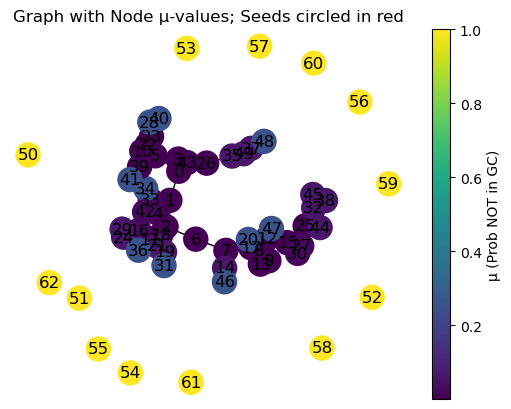

In [6]:
if __name__ == '__main__':
    edge_prob = 1
    graph= create_cluster_tree_network()
    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = 1
        activation_probabilities[(v, u)] = 1
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)

Node 0: 1.0000
Node 1: 1.0000
Node 2: 1.0000
Node 3: 1.0000
Node 4: 1.0000
Node 5: 1.0000
Node 6: 1.0000
Node 7: 1.0000
Node 8: 1.0000
Node 9: 1.0000
Node 10: 1.0000
Node 11: 1.0000
Node 12: 1.0000
Node 13: 1.0000
Node 14: 1.0000
Node 15: 1.0000
Node 16: 1.0000
Node 17: 1.0000
Node 18: 1.0000
Node 19: 1.0000
Node 20: 1.0000
Node 21: 1.0000
Node 22: 1.0000
Node 23: 1.0000
Node 24: 1.0000
Node 25: 1.0000
Node 26: 1.0000
Node 27: 1.0000
Node 28: 1.0000
Node 29: 1.0000
Node 30: 1.0000
Node 31: 1.0000
Node 32: 1.0000
Node 33: 1.0000
Node 34: 1.0000
Node 35: 1.0000
Node 36: 1.0000
Node 37: 1.0000
Node 38: 1.0000
Node 39: 1.0000
Node 40: 1.0000
Node 41: 1.0000
Node 42: 1.0000
Node 43: 1.0000
Node 44: 1.0000
Node 45: 1.0000
Node 46: 1.0000
Node 47: 1.0000
Node 48: 1.0000
Node 49: 1.0000
Node 50: 0.0000
Node 51: 0.0000
Node 52: 0.0000
Node 53: 0.0000
Node 54: 0.0000
Node 55: 0.0000
Node 56: 0.0000
Node 57: 0.0000
Node 58: 0.0000
Node 59: 0.0000


/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


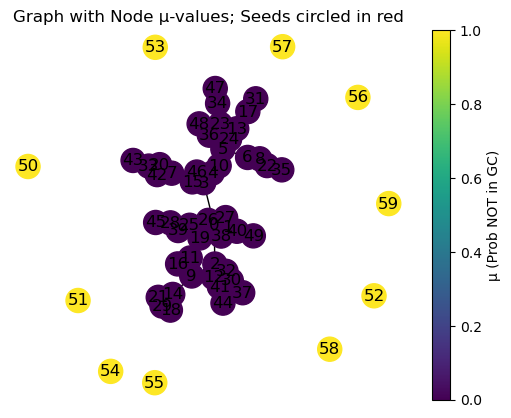

In [7]:
if __name__ == '__main__':
    edge_prob = 1
    num_simulations = 1000
    graph= create_cluster_tree_network()
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

### Results 2: --> good
-  Customer clustered graph with prob of edges 0 Sanity Check


Probability of each node being in the giant component (using percolation Eqs. with p = 0):
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000
Node 4: 0.0000
Node 5: 0.0000
Node 6: 0.0000
Node 7: 0.0000
Node 8: 0.0000
Node 9: 0.0000
Node 10: 0.0000
Node 11: 0.0000
Node 12: 0.0000
Node 13: 0.0000
Node 14: 0.0000
Node 15: 0.0000
Node 16: 0.0000
Node 17: 0.0000
Node 18: 0.0000
Node 19: 0.0000
Node 20: 0.0000
Node 21: 0.0000
Node 22: 0.0000
Node 23: 0.0000
Node 24: 0.0000
Node 25: 0.0000
Node 26: 0.0000
Node 27: 0.0000
Node 28: 0.0000
Node 29: 0.0000
Node 30: 0.0000
Node 31: 0.0000
Node 32: 0.0000
Node 33: 0.0000
Node 34: 0.0000
Node 35: 0.0000
Node 36: 0.0000
Node 37: 0.0000
Node 38: 0.0000
Node 39: 0.0000
Node 40: 0.0000
Node 41: 0.0000
Node 42: 0.0000
Node 43: 0.0000
Node 44: 0.0000
Node 45: 0.0000
Node 46: 0.0000
Node 47: 0.0000
Node 48: 0.0000
Node 49: 0.0000
Node 50: 0.0000
Node 51: 0.0000
Node 52: 0.0000
Node 53: 0.0000
Node 54: 0.0000
Node 55: 0.0000
Node 56: 0.0000
Node 5

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


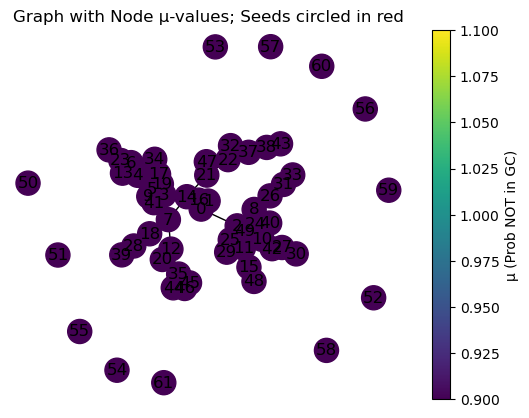

In [8]:
if __name__ == '__main__':
    # Example usage with the percolation theory equations:
    edge_prob = 0
    
    #graph  = nx.barabasi_albert_graph(n=100, m=10, seed=42)
    graph= create_cluster_tree_network()
    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = 0
        activation_probabilities[(v, u)] = 0
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)

Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000
Node 4: 0.0000
Node 5: 0.0000
Node 6: 0.0000
Node 7: 0.0000
Node 8: 0.0000
Node 9: 0.0000
Node 10: 0.0000
Node 11: 0.0000
Node 12: 0.0000
Node 13: 0.0000
Node 14: 0.0000
Node 15: 0.0000
Node 16: 0.0000
Node 17: 0.0000
Node 18: 0.0000
Node 19: 0.0000
Node 20: 0.0000
Node 21: 0.0000
Node 22: 0.0000
Node 23: 0.0000
Node 24: 0.0000
Node 25: 0.0000
Node 26: 0.0000
Node 27: 0.0000
Node 28: 0.0000
Node 29: 0.0000
Node 30: 0.0000
Node 31: 0.0000
Node 32: 0.0000
Node 33: 0.0000
Node 34: 0.0000
Node 35: 0.0000
Node 36: 0.0000
Node 37: 0.0000
Node 38: 0.0000
Node 39: 0.0000
Node 40: 0.0000
Node 41: 0.0000
Node 42: 0.0000
Node 43: 0.0000
Node 44: 0.0000
Node 45: 0.0000
Node 46: 0.0000
Node 47: 0.0000
Node 48: 0.0000
Node 49: 0.0000
Node 50: 0.0000
Node 51: 0.0000
Node 52: 0.0000
Node 53: 0.0000
Node 54: 0.0000
Node 55: 0.0000
Node 56: 0.0000
Node 57: 0.0000
Node 58: 0.0000
Node 59: 0.0000
Node 60: 0.0000
Node 61: 0.0000
Node 62: 0.0000


/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


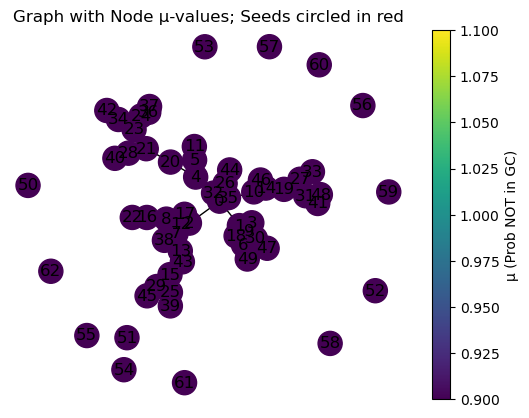

In [9]:
if __name__ == '__main__':
    edge_prob = 0
    num_simulations = 1000
    graph= create_cluster_tree_network()
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

### Results 3 --> good
- Barabasi albert m=3
- p=0.1



Probability of each node being in the giant component (using percolation Eqs. with p = 0.1):
Node 0: 0.6101
Node 1: 0.3748
Node 2: 0.2359
Node 3: 0.4704
Node 4: 0.6309
Node 5: 0.6183
Node 6: 0.5666
Node 7: 0.5676
Node 8: 0.3979
Node 9: 0.2918
Node 10: 0.3945
Node 11: 0.2517
Node 12: 0.3986
Node 13: 0.2679
Node 14: 0.3386
Node 15: 0.2295
Node 16: 0.3225
Node 17: 0.1945
Node 18: 0.2480
Node 19: 0.2666
Node 20: 0.2688
Node 21: 0.2533
Node 22: 0.3150
Node 23: 0.2051
Node 24: 0.2423
Node 25: 0.3456
Node 26: 0.2156
Node 27: 0.2184
Node 28: 0.1608
Node 29: 0.2526
Node 30: 0.2371
Node 31: 0.2153
Node 32: 0.1325
Node 33: 0.2055
Node 34: 0.2798
Node 35: 0.1378
Node 36: 0.1757
Node 37: 0.1774
Node 38: 0.1963
Node 39: 0.1936
Node 40: 0.1861
Node 41: 0.2134
Node 42: 0.1022
Node 43: 0.2205
Node 44: 0.2419
Node 45: 0.2055
Node 46: 0.2335
Node 47: 0.1678
Node 48: 0.1701
Node 49: 0.2034
Node 50: 0.1600
Node 51: 0.2187
Node 52: 0.1643
Node 53: 0.1946
Node 54: 0.1435
Node 55: 0.1678
Node 56: 0.2595
Node

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


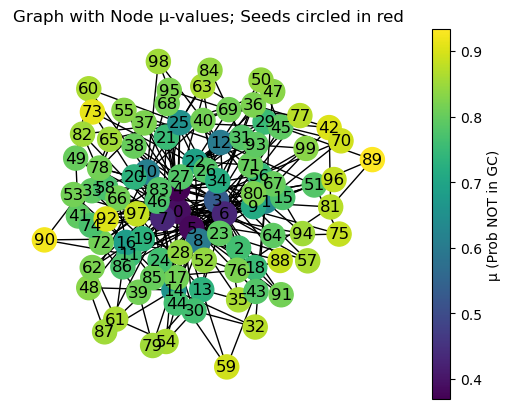

In [10]:
if __name__ == '__main__':
    # Example usage with the percolation theory equations:
    edge_prob = 0.1
    
    graph  = nx.barabasi_albert_graph(n=100, m=3, seed=42)

    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = .1
        activation_probabilities[(v, u)] = .1
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)

Node 0: 0.4150
Node 1: 0.2360
Node 2: 0.1390
Node 3: 0.2570
Node 4: 0.4650
Node 5: 0.4580
Node 6: 0.3670
Node 7: 0.3650
Node 8: 0.2150
Node 9: 0.1690
Node 10: 0.2280
Node 11: 0.1420
Node 12: 0.2470
Node 13: 0.1500
Node 14: 0.1830
Node 15: 0.1190
Node 16: 0.1660
Node 17: 0.0740
Node 18: 0.1330
Node 19: 0.1150
Node 20: 0.1430
Node 21: 0.1360
Node 22: 0.1570
Node 23: 0.1260
Node 24: 0.1180
Node 25: 0.2000
Node 26: 0.1090
Node 27: 0.0830
Node 28: 0.0700
Node 29: 0.1220
Node 30: 0.1220
Node 31: 0.1000
Node 32: 0.0530
Node 33: 0.1030
Node 34: 0.1500
Node 35: 0.0630
Node 36: 0.0690
Node 37: 0.0690
Node 38: 0.1140
Node 39: 0.0990
Node 40: 0.0830
Node 41: 0.1000
Node 42: 0.0300
Node 43: 0.1050
Node 44: 0.1220
Node 45: 0.0900
Node 46: 0.1100
Node 47: 0.0680
Node 48: 0.0630
Node 49: 0.1100
Node 50: 0.0650
Node 51: 0.0950
Node 52: 0.0890
Node 53: 0.0800
Node 54: 0.0790
Node 55: 0.0820
Node 56: 0.1630
Node 57: 0.0840
Node 58: 0.1080
Node 59: 0.0500
Node 60: 0.0530
Node 61: 0.0550
Node 62: 0.0900
No

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


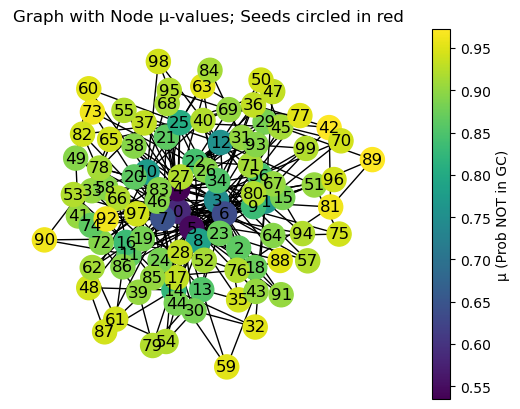

In [11]:
if __name__ == '__main__':
    edge_prob = .1
    num_simulations = 1000
    graph  = nx.barabasi_albert_graph(n=100, m=3, seed=42)
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

### Results 4 --> good
- Barabasi albert m=3
- p=0.9


Probability of each node being in the giant component (using percolation Eqs. with p = 0.9):
Node 0: 1.0000
Node 1: 1.0000
Node 2: 0.9990
Node 3: 1.0000
Node 4: 1.0000
Node 5: 1.0000
Node 6: 1.0000
Node 7: 1.0000
Node 8: 1.0000
Node 9: 1.0000
Node 10: 1.0000
Node 11: 0.9998
Node 12: 1.0000
Node 13: 1.0000
Node 14: 1.0000
Node 15: 0.9998
Node 16: 1.0000
Node 17: 0.9990
Node 18: 1.0000
Node 19: 1.0000
Node 20: 1.0000
Node 21: 0.9999
Node 22: 1.0000
Node 23: 1.0000
Node 24: 0.9999
Node 25: 1.0000
Node 26: 1.0000
Node 27: 1.0000
Node 28: 0.9990
Node 29: 1.0000
Node 30: 1.0000
Node 31: 1.0000
Node 32: 0.9989
Node 33: 0.9998
Node 34: 1.0000
Node 35: 0.9990
Node 36: 0.9999
Node 37: 0.9999
Node 38: 0.9990
Node 39: 1.0000
Node 40: 0.9990
Node 41: 1.0000
Node 42: 0.9998
Node 43: 0.9998
Node 44: 0.9999
Node 45: 1.0000
Node 46: 1.0000
Node 47: 0.9990
Node 48: 0.9998
Node 49: 1.0000
Node 50: 0.9989
Node 51: 1.0000
Node 52: 0.9990
Node 53: 0.9998
Node 54: 0.9998
Node 55: 0.9987
Node 56: 1.0000
Node

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


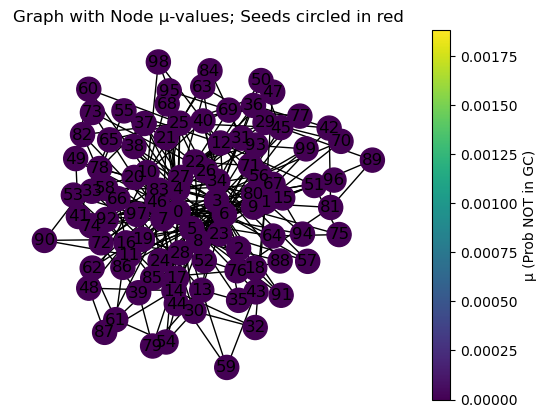

In [12]:
if __name__ == '__main__':
    # Example usage with the percolation theory equations:
    edge_prob = 0.9
    
    graph  = nx.barabasi_albert_graph(n=100, m=3, seed=42)
    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = .9
        activation_probabilities[(v, u)] = .9
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)

Node 0: 1.0000
Node 1: 1.0000
Node 2: 0.9980
Node 3: 1.0000
Node 4: 1.0000
Node 5: 1.0000
Node 6: 1.0000
Node 7: 1.0000
Node 8: 1.0000
Node 9: 1.0000
Node 10: 1.0000
Node 11: 1.0000
Node 12: 1.0000
Node 13: 1.0000
Node 14: 1.0000
Node 15: 1.0000
Node 16: 1.0000
Node 17: 0.9980
Node 18: 1.0000
Node 19: 1.0000
Node 20: 1.0000
Node 21: 1.0000
Node 22: 1.0000
Node 23: 1.0000
Node 24: 1.0000
Node 25: 1.0000
Node 26: 1.0000
Node 27: 1.0000
Node 28: 0.9990
Node 29: 1.0000
Node 30: 1.0000
Node 31: 1.0000
Node 32: 0.9980
Node 33: 1.0000
Node 34: 1.0000
Node 35: 1.0000
Node 36: 1.0000
Node 37: 1.0000
Node 38: 1.0000
Node 39: 1.0000
Node 40: 0.9990
Node 41: 1.0000
Node 42: 1.0000
Node 43: 1.0000
Node 44: 1.0000
Node 45: 1.0000
Node 46: 1.0000
Node 47: 0.9990
Node 48: 1.0000
Node 49: 1.0000
Node 50: 0.9970
Node 51: 1.0000
Node 52: 1.0000
Node 53: 1.0000
Node 54: 1.0000
Node 55: 0.9980
Node 56: 1.0000
Node 57: 0.9980
Node 58: 1.0000
Node 59: 1.0000
Node 60: 1.0000
Node 61: 1.0000
Node 62: 1.0000
No

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


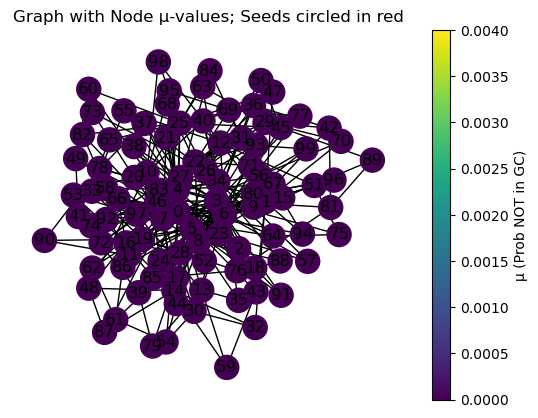

In [13]:
if __name__ == '__main__':
    edge_prob = .9
    num_simulations = 1000
    graph  = nx.barabasi_albert_graph(n=100, m=3, seed=42)
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

### Results 5 --> good
- Barabasi albert m=10
- p=0.1


Probability of each node being in the giant component (using percolation Eqs. with p = 0.1):
Node 0: 0.9890
Node 1: 0.7217
Node 2: 0.8348
Node 3: 0.8315
Node 4: 0.5075
Node 5: 0.7952
Node 6: 0.3470
Node 7: 0.6372
Node 8: 0.8398
Node 9: 0.8603
Node 10: 0.9010
Node 11: 0.9801
Node 12: 0.9741
Node 13: 0.9624
Node 14: 0.9372
Node 15: 0.9348
Node 16: 0.9448
Node 17: 0.9199
Node 18: 0.9392
Node 19: 0.7730
Node 20: 0.8567
Node 21: 0.9305
Node 22: 0.8592
Node 23: 0.9105
Node 24: 0.8583
Node 25: 0.8865
Node 26: 0.9295
Node 27: 0.7702
Node 28: 0.8075
Node 29: 0.8605
Node 30: 0.7609
Node 31: 0.7907
Node 32: 0.8360
Node 33: 0.8052
Node 34: 0.7952
Node 35: 0.7412
Node 36: 0.7260
Node 37: 0.7819
Node 38: 0.7119
Node 39: 0.8067
Node 40: 0.6463
Node 41: 0.7608
Node 42: 0.6328
Node 43: 0.7308
Node 44: 0.7133
Node 45: 0.7584
Node 46: 0.7472
Node 47: 0.6737
Node 48: 0.7115
Node 49: 0.6804
Node 50: 0.6370
Node 51: 0.6958
Node 52: 0.7139
Node 53: 0.7319
Node 54: 0.7103
Node 55: 0.6788
Node 56: 0.6348
Node

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


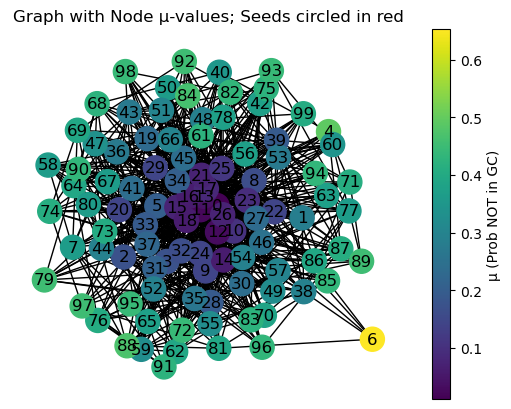

In [14]:
if __name__ == '__main__':
    # Example usage with the percolation theory equations:
    edge_prob = 0.1
    
    graph  = nx.barabasi_albert_graph(n=100, m=10, seed=42)

    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = .1
        activation_probabilities[(v, u)] = .1
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)

Node 0: 0.9860
Node 1: 0.7060
Node 2: 0.8130
Node 3: 0.8010
Node 4: 0.5080
Node 5: 0.7700
Node 6: 0.3380
Node 7: 0.6340
Node 8: 0.8410
Node 9: 0.8410
Node 10: 0.9010
Node 11: 0.9760
Node 12: 0.9710
Node 13: 0.9590
Node 14: 0.9130
Node 15: 0.9440
Node 16: 0.9370
Node 17: 0.9100
Node 18: 0.9230
Node 19: 0.7700
Node 20: 0.8390
Node 21: 0.9180
Node 22: 0.8540
Node 23: 0.9180
Node 24: 0.8260
Node 25: 0.8510
Node 26: 0.9290
Node 27: 0.7480
Node 28: 0.8170
Node 29: 0.8610
Node 30: 0.7420
Node 31: 0.7700
Node 32: 0.8400
Node 33: 0.7900
Node 34: 0.8030
Node 35: 0.7220
Node 36: 0.7220
Node 37: 0.7710
Node 38: 0.7110
Node 39: 0.7950
Node 40: 0.6530
Node 41: 0.7520
Node 42: 0.6440
Node 43: 0.7280
Node 44: 0.6910
Node 45: 0.7430
Node 46: 0.7120
Node 47: 0.6450
Node 48: 0.6920
Node 49: 0.6640
Node 50: 0.6290
Node 51: 0.6990
Node 52: 0.7100
Node 53: 0.7340
Node 54: 0.6920
Node 55: 0.6660
Node 56: 0.6300
Node 57: 0.6930
Node 58: 0.6340
Node 59: 0.6690
Node 60: 0.6530
Node 61: 0.5560
Node 62: 0.5790
No

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


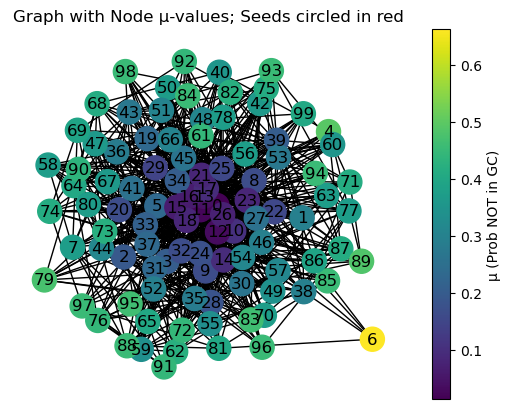

In [15]:
if __name__ == '__main__':
    edge_prob = .1
    num_simulations = 1000
    graph  = nx.barabasi_albert_graph(n=100, m=10, seed=42)
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

### Results 6 --> good
- Barabasi albert m=10
- p=0.9


Probability of each node being in the giant component (using percolation Eqs. with p = 0.9):
Node 0: 1.0000
Node 1: 1.0000
Node 2: 1.0000
Node 3: 1.0000
Node 4: 1.0000
Node 5: 1.0000
Node 6: 1.0000
Node 7: 1.0000
Node 8: 1.0000
Node 9: 1.0000
Node 10: 1.0000
Node 11: 1.0000
Node 12: 1.0000
Node 13: 1.0000
Node 14: 1.0000
Node 15: 1.0000
Node 16: 1.0000
Node 17: 1.0000
Node 18: 1.0000
Node 19: 1.0000
Node 20: 1.0000
Node 21: 1.0000
Node 22: 1.0000
Node 23: 1.0000
Node 24: 1.0000
Node 25: 1.0000
Node 26: 1.0000
Node 27: 1.0000
Node 28: 1.0000
Node 29: 1.0000
Node 30: 1.0000
Node 31: 1.0000
Node 32: 1.0000
Node 33: 1.0000
Node 34: 1.0000
Node 35: 1.0000
Node 36: 1.0000
Node 37: 1.0000
Node 38: 1.0000
Node 39: 1.0000
Node 40: 1.0000
Node 41: 1.0000
Node 42: 1.0000
Node 43: 1.0000
Node 44: 1.0000
Node 45: 1.0000
Node 46: 1.0000
Node 47: 1.0000
Node 48: 1.0000
Node 49: 1.0000
Node 50: 1.0000
Node 51: 1.0000
Node 52: 1.0000
Node 53: 1.0000
Node 54: 1.0000
Node 55: 1.0000
Node 56: 1.0000
Node

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


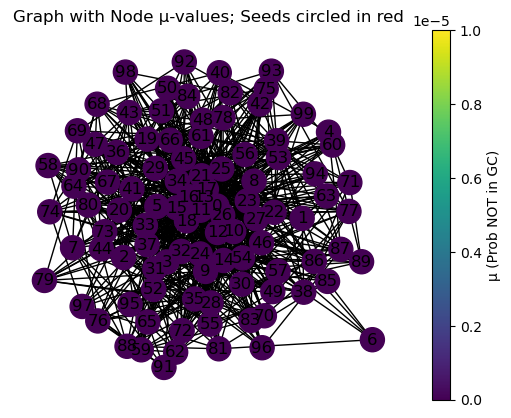

In [16]:
if __name__ == '__main__':
    # Example usage with the percolation theory equations:
    edge_prob = 0.9
    
    graph  = nx.barabasi_albert_graph(n=100, m=10, seed=42)

    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = .9
        activation_probabilities[(v, u)] = .9
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)

Node 0: 1.0000
Node 1: 1.0000
Node 2: 1.0000
Node 3: 1.0000
Node 4: 1.0000
Node 5: 1.0000
Node 6: 1.0000
Node 7: 1.0000
Node 8: 1.0000
Node 9: 1.0000
Node 10: 1.0000
Node 11: 1.0000
Node 12: 1.0000
Node 13: 1.0000
Node 14: 1.0000
Node 15: 1.0000
Node 16: 1.0000
Node 17: 1.0000
Node 18: 1.0000
Node 19: 1.0000
Node 20: 1.0000
Node 21: 1.0000
Node 22: 1.0000
Node 23: 1.0000
Node 24: 1.0000
Node 25: 1.0000
Node 26: 1.0000
Node 27: 1.0000
Node 28: 1.0000
Node 29: 1.0000
Node 30: 1.0000
Node 31: 1.0000
Node 32: 1.0000
Node 33: 1.0000
Node 34: 1.0000
Node 35: 1.0000
Node 36: 1.0000
Node 37: 1.0000
Node 38: 1.0000
Node 39: 1.0000
Node 40: 1.0000
Node 41: 1.0000
Node 42: 1.0000
Node 43: 1.0000
Node 44: 1.0000
Node 45: 1.0000
Node 46: 1.0000
Node 47: 1.0000
Node 48: 1.0000
Node 49: 1.0000
Node 50: 1.0000
Node 51: 1.0000
Node 52: 1.0000
Node 53: 1.0000
Node 54: 1.0000
Node 55: 1.0000
Node 56: 1.0000
Node 57: 1.0000
Node 58: 1.0000
Node 59: 1.0000
Node 60: 1.0000
Node 61: 1.0000
Node 62: 1.0000
No

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


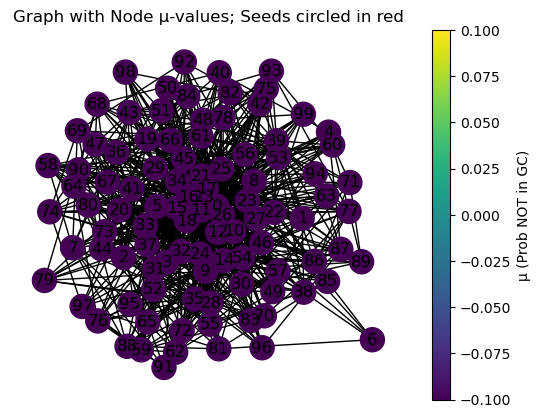

In [17]:
if __name__ == '__main__':
    edge_prob = .9
    num_simulations = 1000
    graph  = nx.barabasi_albert_graph(n=100, m=10, seed=42)
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

Node 0: 0.9870
Node 1: 0.7380
Node 2: 0.8460
Node 3: 0.8370
Node 4: 0.5210
Node 5: 0.7700
Node 6: 0.3480
Node 7: 0.6530
Node 8: 0.8430
Node 9: 0.8600
Node 10: 0.9050
Node 11: 0.9790
Node 12: 0.9730
Node 13: 0.9490
Node 14: 0.9340
Node 15: 0.9260
Node 16: 0.9360
Node 17: 0.9200
Node 18: 0.9490
Node 19: 0.7740
Node 20: 0.8450
Node 21: 0.9190
Node 22: 0.8630
Node 23: 0.9060
Node 24: 0.8540
Node 25: 0.9010
Node 26: 0.9430
Node 27: 0.7500
Node 28: 0.8070
Node 29: 0.8810
Node 30: 0.7610
Node 31: 0.7940
Node 32: 0.8580
Node 33: 0.8130
Node 34: 0.8180
Node 35: 0.7780
Node 36: 0.7250
Node 37: 0.8000
Node 38: 0.7080
Node 39: 0.8050
Node 40: 0.6440
Node 41: 0.7570
Node 42: 0.6050
Node 43: 0.7490
Node 44: 0.7300
Node 45: 0.7790
Node 46: 0.7370
Node 47: 0.6810
Node 48: 0.7290
Node 49: 0.6510
Node 50: 0.6620
Node 51: 0.7120
Node 52: 0.6910
Node 53: 0.7690
Node 54: 0.7010
Node 55: 0.6700
Node 56: 0.6440
Node 57: 0.7150
Node 58: 0.6710
Node 59: 0.6750
Node 60: 0.6670
Node 61: 0.5820
Node 62: 0.6290
No

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


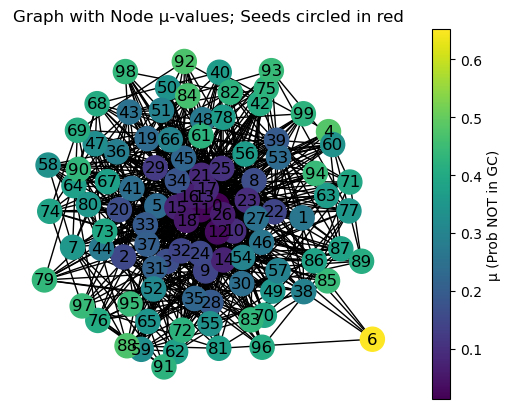

In [18]:
if __name__ == '__main__':
    edge_prob = .1
    num_simulations = 1000
    graph  = nx.barabasi_albert_graph(n=100, m=10, seed=42)
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

### Results 7 --> worst but still very close
- G = nx.balanced_tree(r=3, h=3)
- p =0.1


Probability of each node being in the giant component (using percolation Eqs. with p = 0.1):
Node 0: 0.0613
Node 1: 0.0748
Node 2: 0.0748
Node 3: 0.0748
Node 4: 0.0808
Node 5: 0.0808
Node 6: 0.0808
Node 7: 0.0808
Node 8: 0.0808
Node 9: 0.0808
Node 10: 0.0808
Node 11: 0.0808
Node 12: 0.0808
Node 13: 0.0808
Node 14: 0.0808
Node 15: 0.0808
Node 16: 0.0808
Node 17: 0.0808
Node 18: 0.0808
Node 19: 0.0808
Node 20: 0.0808
Node 21: 0.0808
Node 22: 0.0808
Node 23: 0.0808
Node 24: 0.0808
Node 25: 0.0808
Node 26: 0.0808
Node 27: 0.0808
Node 28: 0.0808
Node 29: 0.0808
Node 30: 0.0808
Node 31: 0.0808
Node 32: 0.0808
Node 33: 0.0808
Node 34: 0.0808
Node 35: 0.0808
Node 36: 0.0808
Node 37: 0.0808
Node 38: 0.0808
Node 39: 0.0808
Node 40: 0.0209
Node 41: 0.0209
Node 42: 0.0209
Node 43: 0.0209
Node 44: 0.0209
Node 45: 0.0209
Node 46: 0.0209
Node 47: 0.0209
Node 48: 0.0209
Node 49: 0.0209
Node 50: 0.0209
Node 51: 0.0209
Node 52: 0.0209
Node 53: 0.0209
Node 54: 0.0209
Node 55: 0.0209
Node 56: 0.0209
Node

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


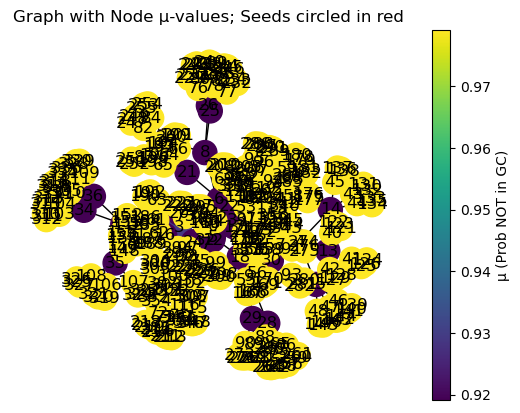

In [19]:
if __name__ == '__main__':
    # Example usage with the percolation theory equations:
    edge_prob = 0.1
    
    graph   = nx.balanced_tree(r=3, h=5)

    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = .1
        activation_probabilities[(v, u)] = .1
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)

Node 0: 0.0470
Node 1: 0.0690
Node 2: 0.0730
Node 3: 0.0780
Node 4: 0.0600
Node 5: 0.0670
Node 6: 0.0670
Node 7: 0.0740
Node 8: 0.0560
Node 9: 0.0690
Node 10: 0.0800
Node 11: 0.0500
Node 12: 0.0550
Node 13: 0.0400
Node 14: 0.0320
Node 15: 0.0470
Node 16: 0.0490
Node 17: 0.0540
Node 18: 0.0360
Node 19: 0.0380
Node 20: 0.0370
Node 21: 0.0490
Node 22: 0.0590
Node 23: 0.0440
Node 24: 0.0390
Node 25: 0.0410
Node 26: 0.0290
Node 27: 0.0390
Node 28: 0.0290
Node 29: 0.0360
Node 30: 0.0430
Node 31: 0.0430
Node 32: 0.0410
Node 33: 0.0380
Node 34: 0.0310
Node 35: 0.0310
Node 36: 0.0310
Node 37: 0.0270
Node 38: 0.0330
Node 39: 0.0330
Node 40: 0.0160
Node 41: 0.0140
Node 42: 0.0170
Node 43: 0.0130
Node 44: 0.0090
Node 45: 0.0090
Node 46: 0.0170
Node 47: 0.0160
Node 48: 0.0160
Node 49: 0.0230
Node 50: 0.0130
Node 51: 0.0200
Node 52: 0.0200
Node 53: 0.0180
Node 54: 0.0250
Node 55: 0.0090
Node 56: 0.0140
Node 57: 0.0150
Node 58: 0.0130
Node 59: 0.0180
Node 60: 0.0140
Node 61: 0.0170
Node 62: 0.0130
No

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


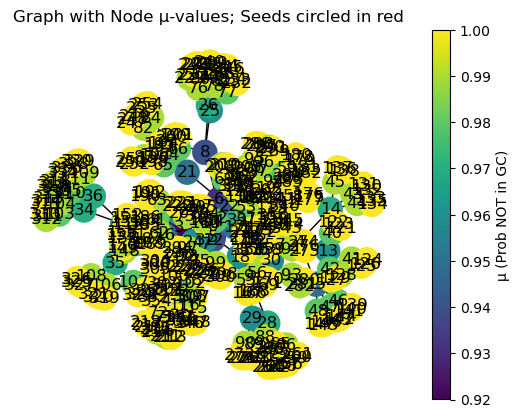

In [20]:
if __name__ == '__main__':
    edge_prob = .1
    num_simulations = 1000
    graph   = nx.balanced_tree(r=3, h=5)
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    for node, prob in empirical_gc_probs.items():
        print(f"Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

### Results 8 --> worse but not awaful, mine overstiamtes as it should
- G = nx.balanced_tree(r=3, h=3)
- p =0.9


Probability of each node being in the giant component (using percolation Eqs. with p = 0.9):
Node 0: 0.9978
Node 1: 0.9996
Node 2: 0.9996
Node 3: 0.9996
Node 4: 0.9997
Node 5: 0.9997
Node 6: 0.9997
Node 7: 0.9997
Node 8: 0.9997
Node 9: 0.9997
Node 10: 0.9997
Node 11: 0.9997
Node 12: 0.9997
Node 13: 0.9997
Node 14: 0.9997
Node 15: 0.9997
Node 16: 0.9997
Node 17: 0.9997
Node 18: 0.9997
Node 19: 0.9997
Node 20: 0.9997
Node 21: 0.9997
Node 22: 0.9997
Node 23: 0.9997
Node 24: 0.9997
Node 25: 0.9997
Node 26: 0.9997
Node 27: 0.9997
Node 28: 0.9997
Node 29: 0.9997
Node 30: 0.9997
Node 31: 0.9997
Node 32: 0.9997
Node 33: 0.9997
Node 34: 0.9997
Node 35: 0.9997
Node 36: 0.9997
Node 37: 0.9997
Node 38: 0.9997
Node 39: 0.9997
Node 40: 0.8691
Node 41: 0.8691
Node 42: 0.8691
Node 43: 0.8691
Node 44: 0.8691
Node 45: 0.8691
Node 46: 0.8691
Node 47: 0.8691
Node 48: 0.8691
Node 49: 0.8691
Node 50: 0.8691
Node 51: 0.8691
Node 52: 0.8691
Node 53: 0.8691
Node 54: 0.8691
Node 55: 0.8691
Node 56: 0.8691
Node

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


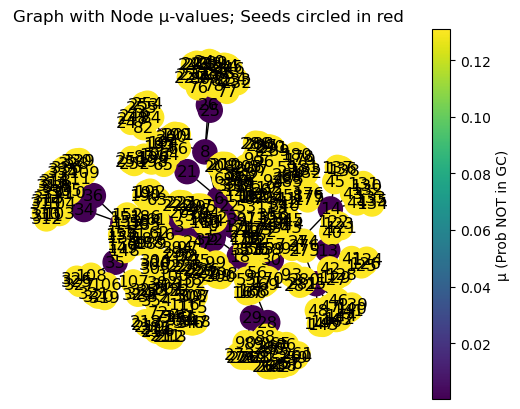

In [21]:
if __name__ == '__main__':
    # Example usage with the percolation theory equations:
    edge_prob = 0.9
    
    graph   = nx.balanced_tree(r=3, h=5)

    activation_probabilities = {}
    for u, v in graph.edges():
        activation_probabilities[(u, v)] = .9
        activation_probabilities[(v, u)] = .9
    mu_values = compute_not_in_giant_component_probabilities(graph, activation_probabilities=activation_probabilities)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, mu_val in mu_values.items():
        probability_in_gc = 1 - mu_val
        print(f"Node {node}: {probability_in_gc:.4f}")
    plot_graph(graph, mu_values)


Probability of each node being in the giant component (using percolation Eqs. with p = 0.9):
 Node 0: 0.9780
 Node 1: 0.8970
 Node 2: 0.9090
 Node 3: 0.8980
 Node 4: 0.8060
 Node 5: 0.7920
 Node 6: 0.8100
 Node 7: 0.8110
 Node 8: 0.8080
 Node 9: 0.8270
 Node 10: 0.8170
 Node 11: 0.8020
 Node 12: 0.8070
 Node 13: 0.7150
 Node 14: 0.7250
 Node 15: 0.7150
 Node 16: 0.7070
 Node 17: 0.7110
 Node 18: 0.7070
 Node 19: 0.7440
 Node 20: 0.7150
 Node 21: 0.7280
 Node 22: 0.7320
 Node 23: 0.7230
 Node 24: 0.7280
 Node 25: 0.7230
 Node 26: 0.7220
 Node 27: 0.7460
 Node 28: 0.7530
 Node 29: 0.7460
 Node 30: 0.7380
 Node 31: 0.7310
 Node 32: 0.7290
 Node 33: 0.7520
 Node 34: 0.7180
 Node 35: 0.7200
 Node 36: 0.7140
 Node 37: 0.7110
 Node 38: 0.7150
 Node 39: 0.7220
 Node 40: 0.6450
 Node 41: 0.6330
 Node 42: 0.6540
 Node 43: 0.6380
 Node 44: 0.6360
 Node 45: 0.6620
 Node 46: 0.6540
 Node 47: 0.6380
 Node 48: 0.6510
 Node 49: 0.6420
 Node 50: 0.6290
 Node 51: 0.6280
 Node 52: 0.6510
 Node 53: 0.646

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


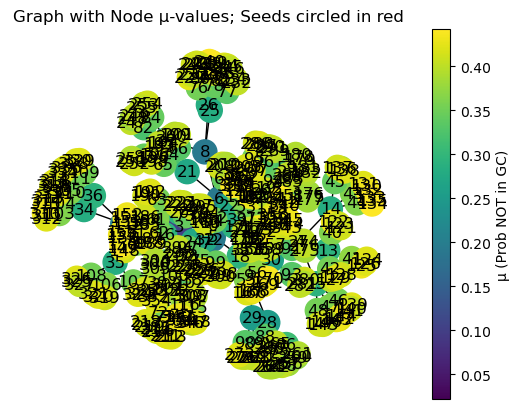

In [22]:
if __name__ == '__main__':
    edge_prob = .9
    num_simulations = 1000
    graph   = nx.balanced_tree(r=3, h=5)
    
    empirical_gc_probs = percolated_gc_probabilities(graph, p=edge_prob, num_simulations=num_simulations)
    print(f"\nProbability of each node being in the giant component (using percolation Eqs. with p = {edge_prob}):")
    for node, prob in empirical_gc_probs.items():
        print(f" Node {node}: {prob:.4f}")
    not_in_gc_prob= {node: 1 - prob for node, prob in empirical_gc_probs.items()}
    plot_graph(graph, not_in_gc_prob)

# MP VS BRUTE FORCE HEAD TO HEAD ON BARABASI ALBERT

N is 100


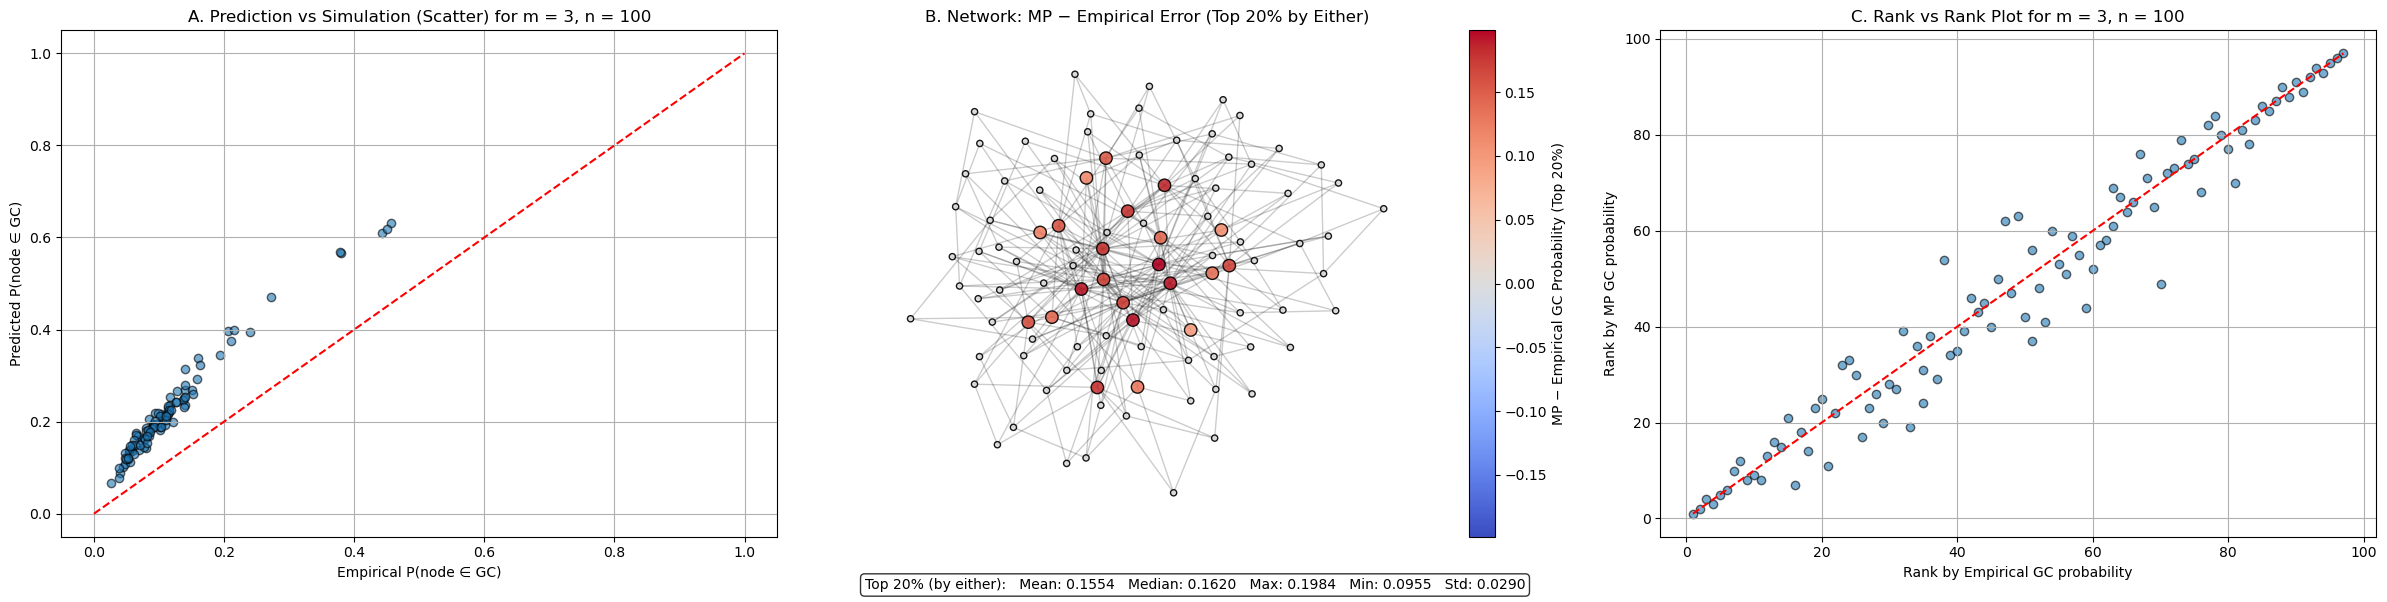

N is 100


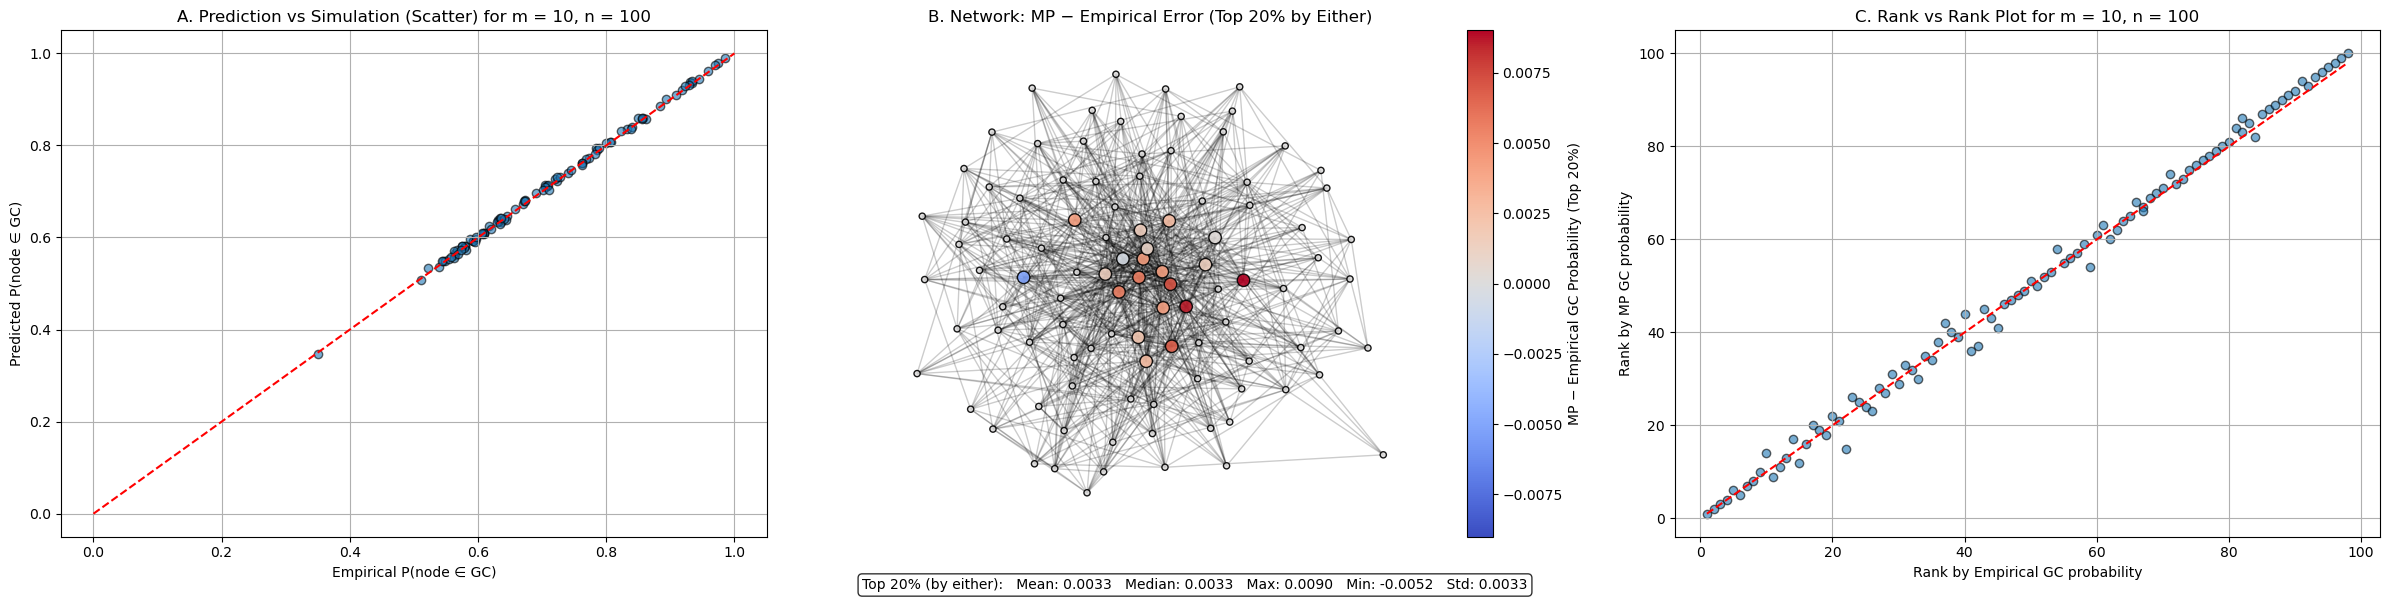

N is 100


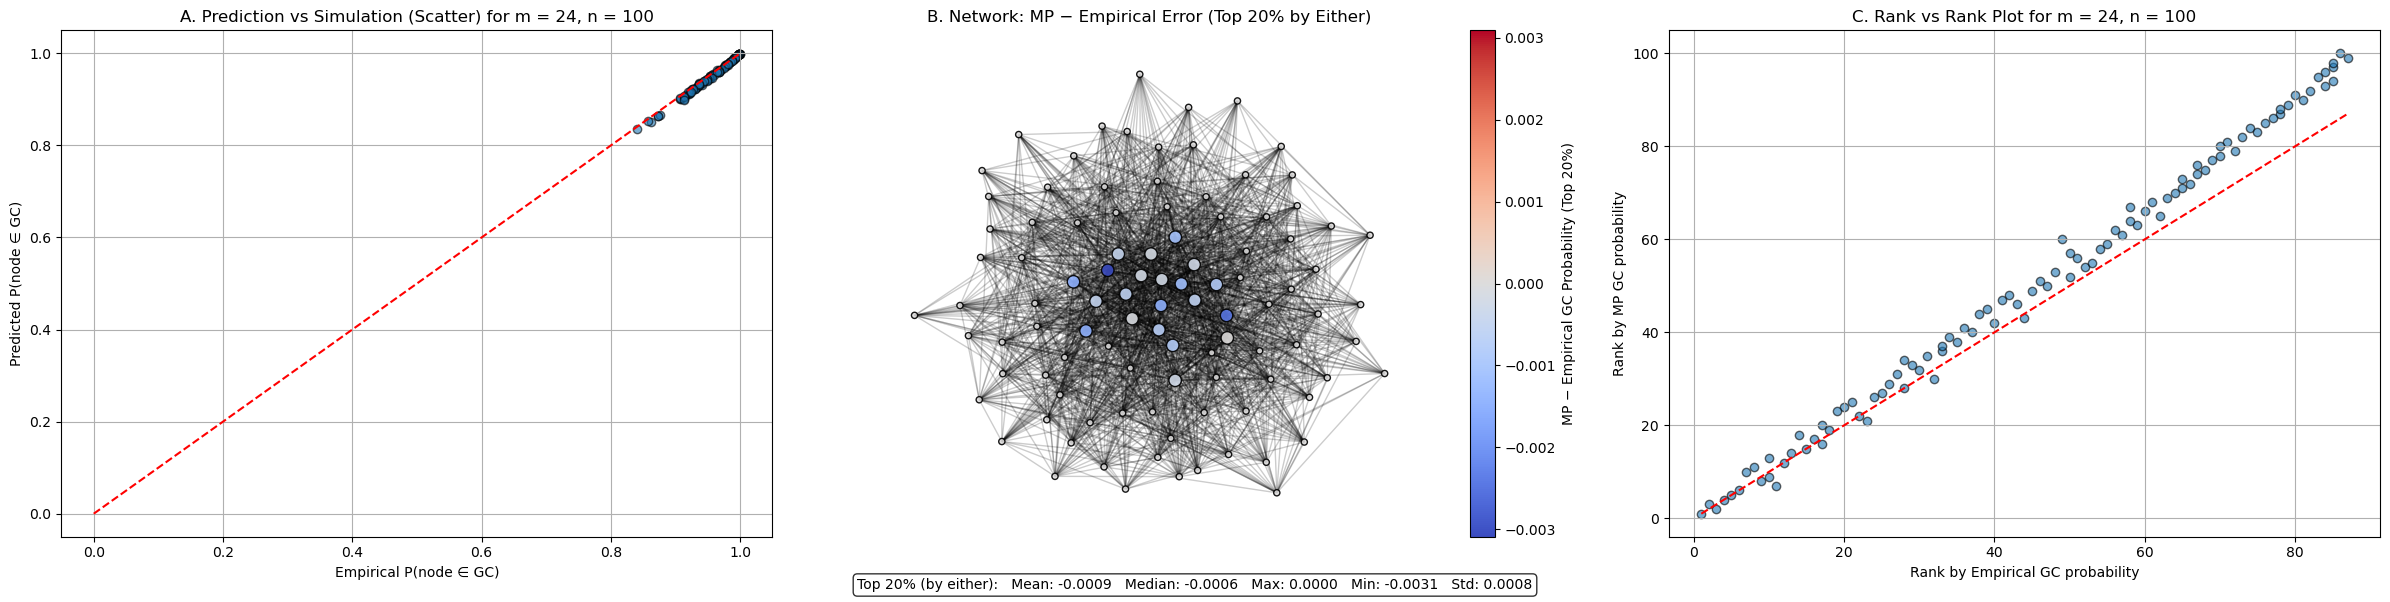

N is 100


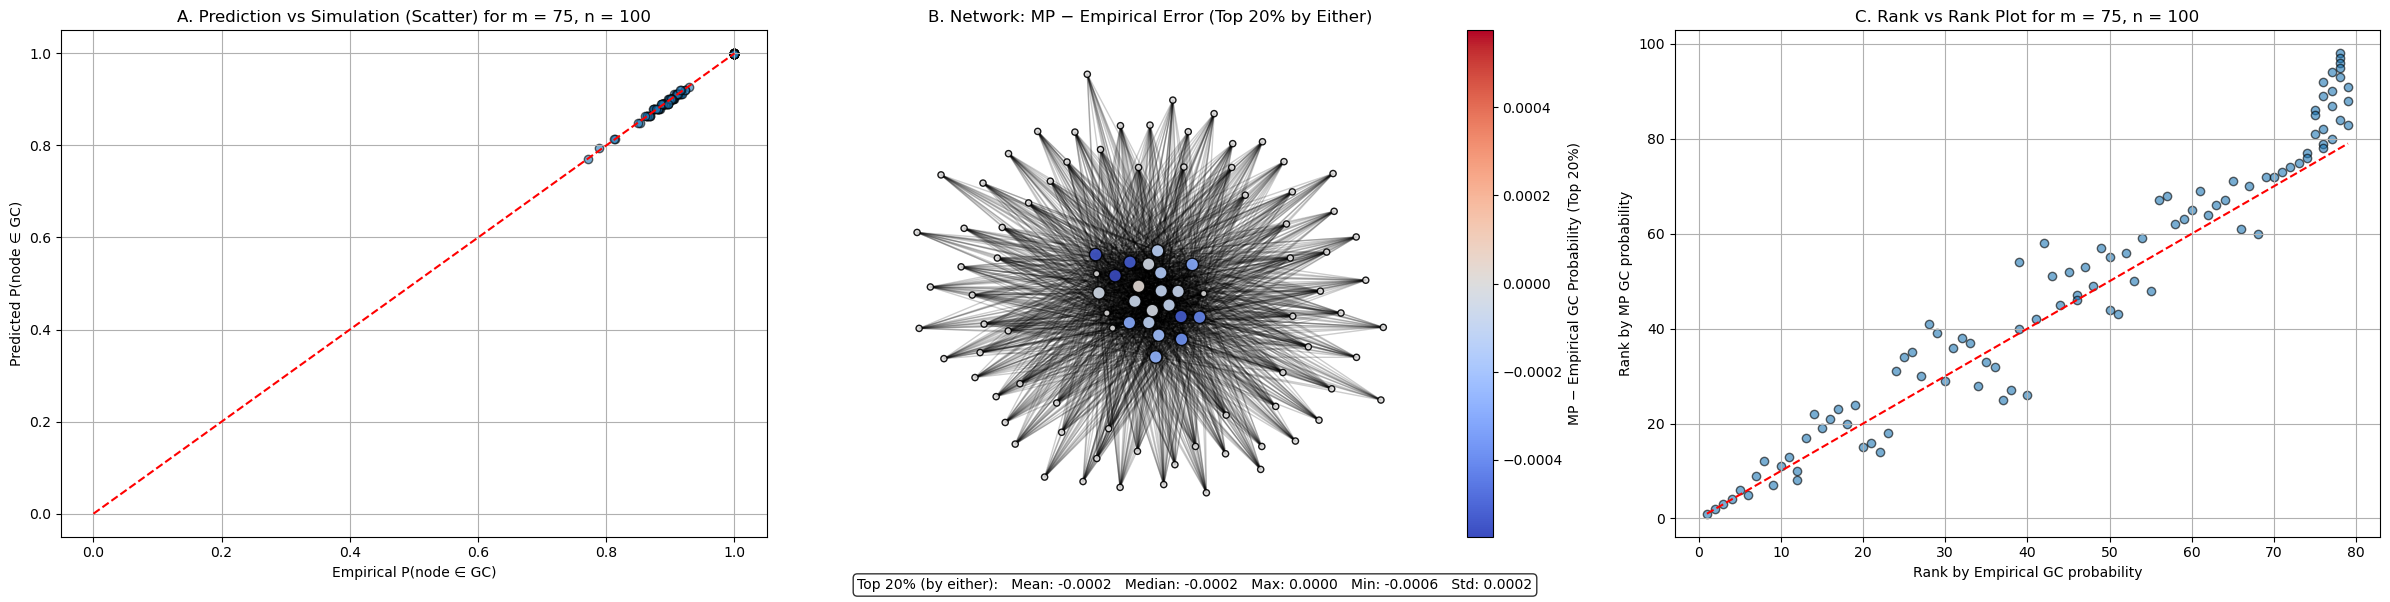

N is 200


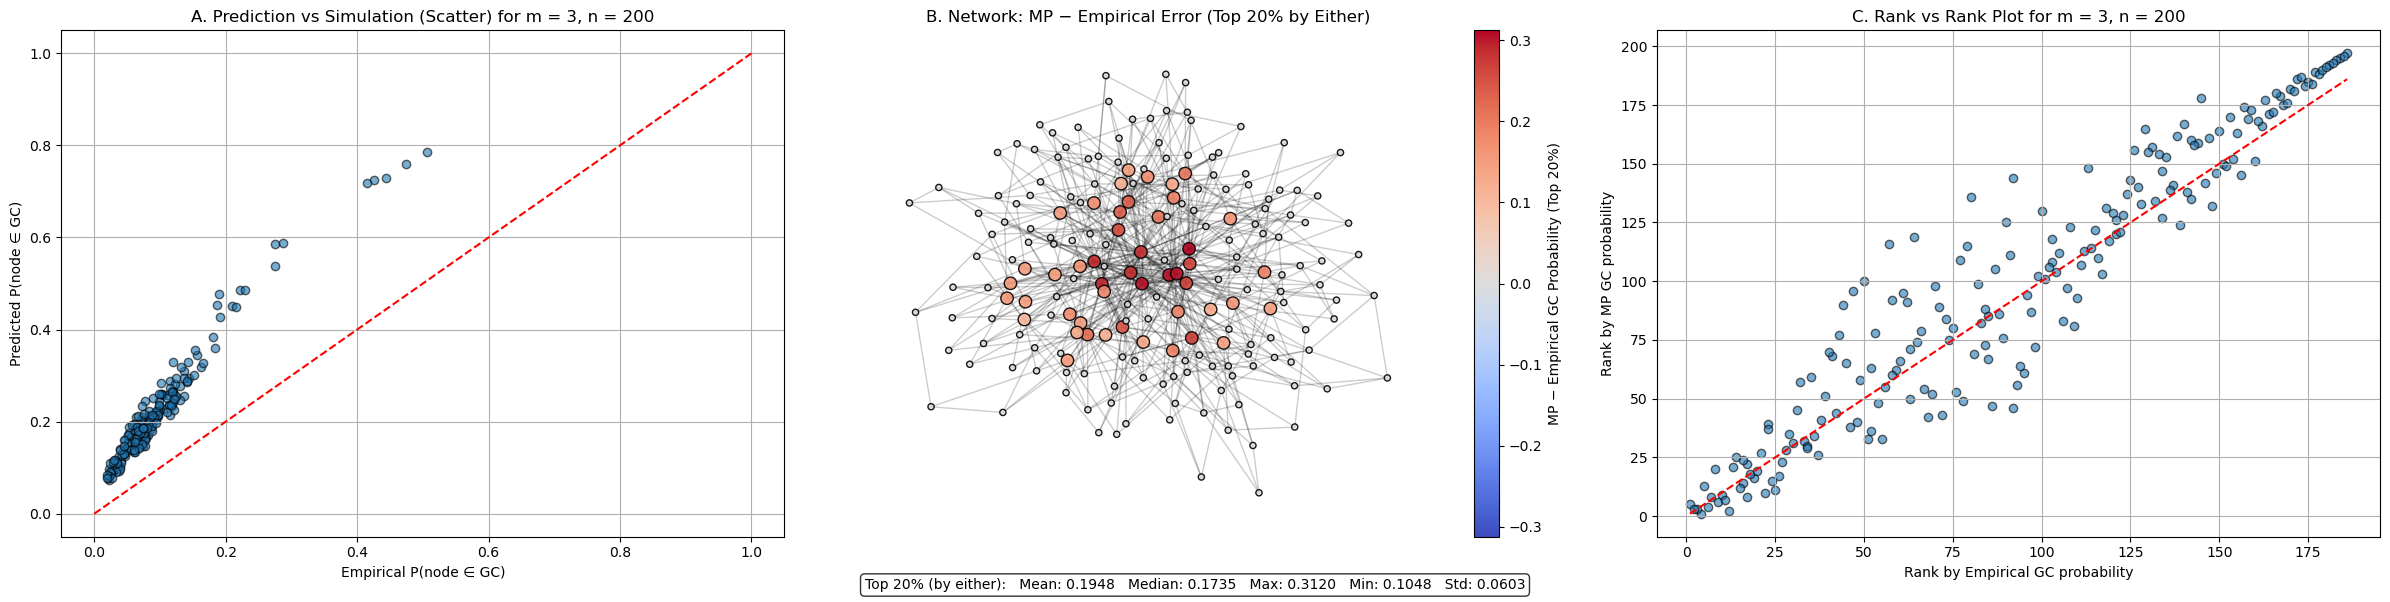

N is 200


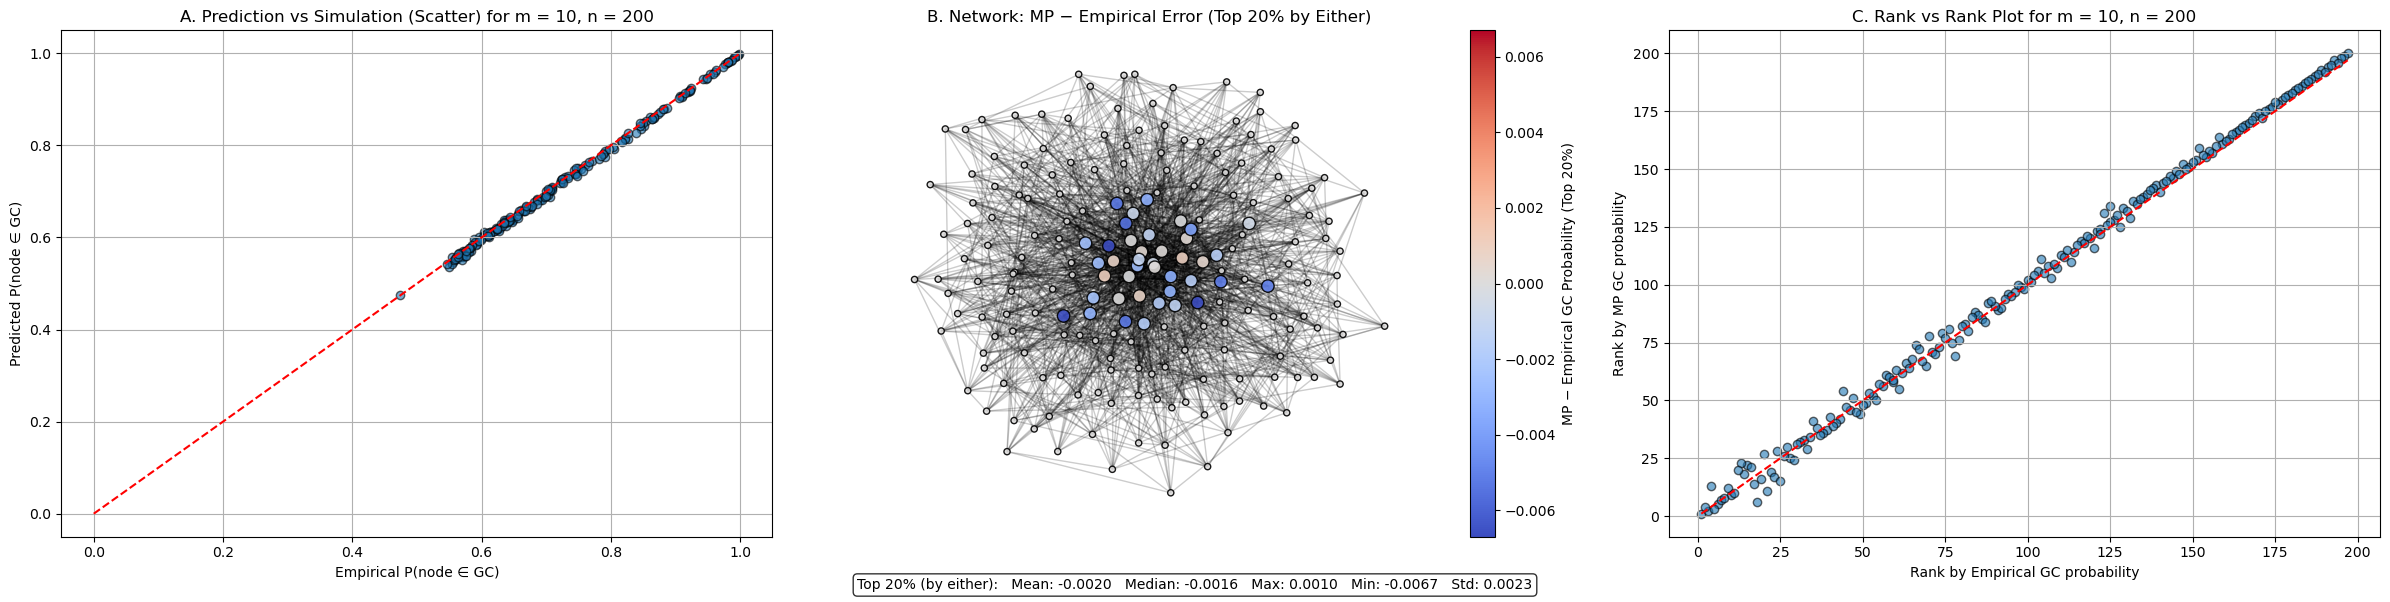

N is 200


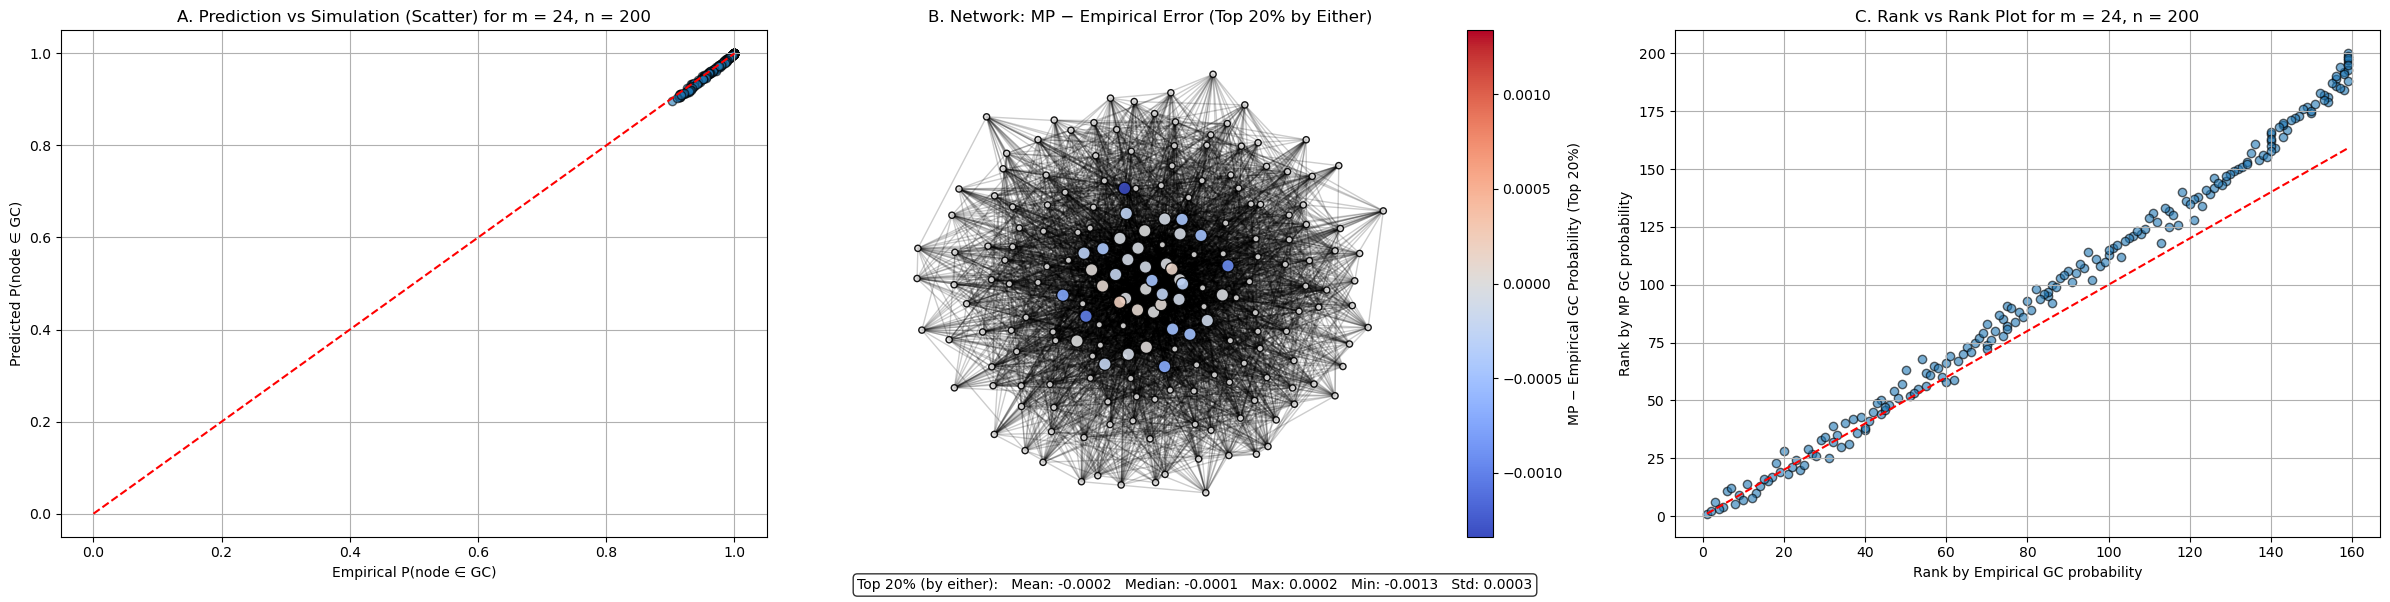

N is 200


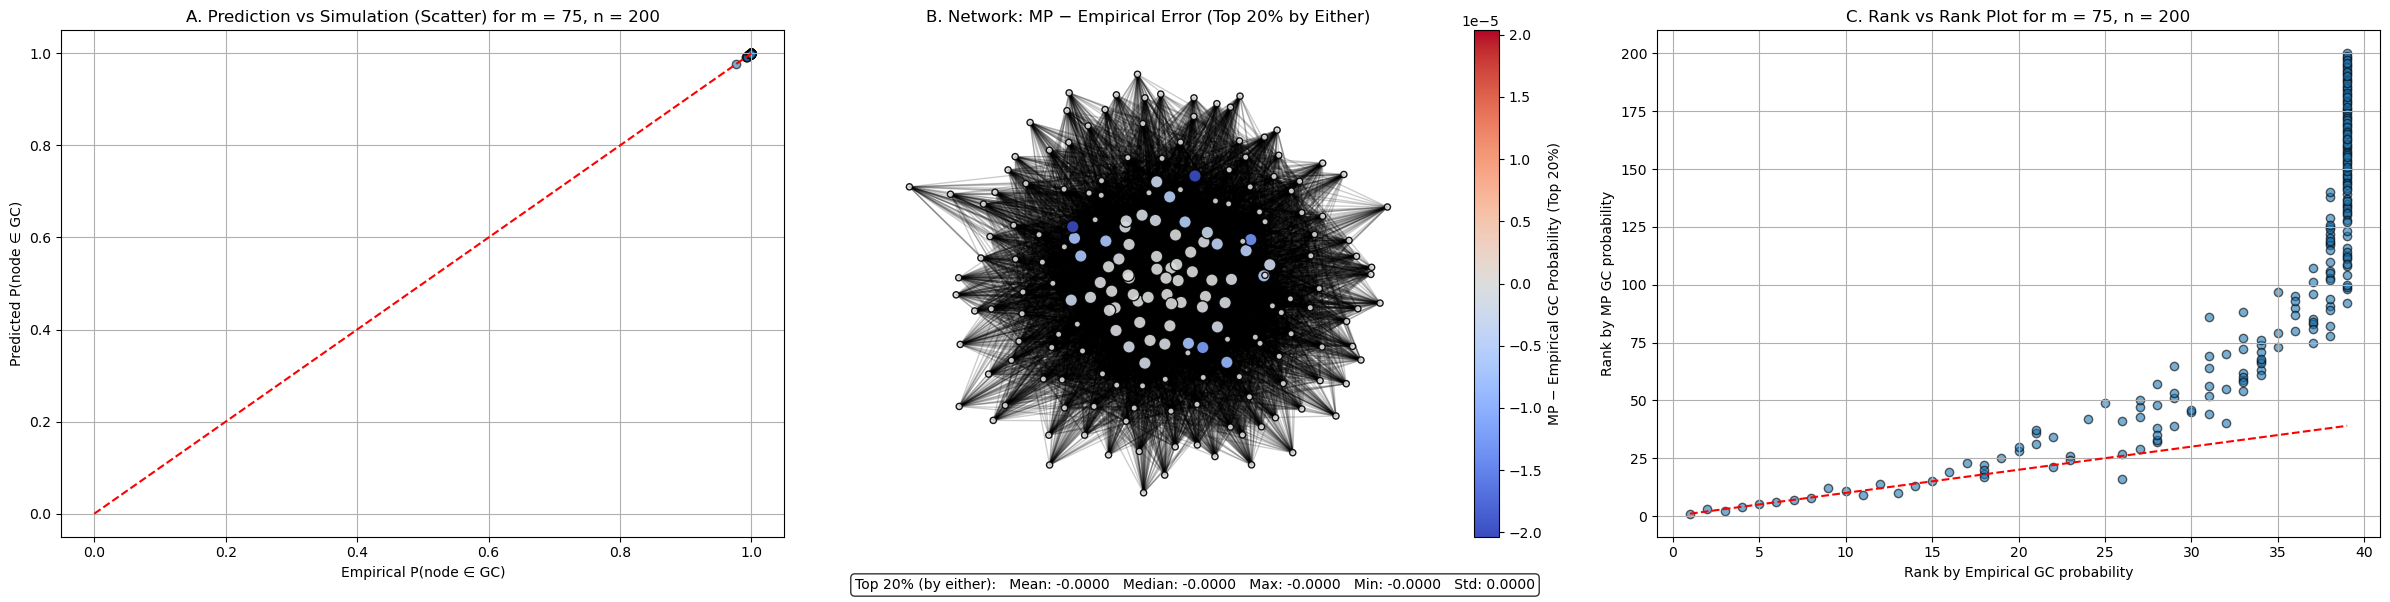

In [23]:


def compare_gc_probabilities_2(empirical_gc_probs, mp_gc_probs, G, m, n):
    nodes = sorted(empirical_gc_probs.keys())
    empirical = np.array([empirical_gc_probs[node] for node in nodes])
    predicted = np.array([mp_gc_probs[node] for node in nodes])

    # Use dense ranking
    empirical_ranks = rankdata(empirical, method='dense')
    mp_ranks = rankdata(predicted, method='dense')

    # === MAKE GROUPED PLOTS ===
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # === Plot A: Scatter ===
    axes[0].scatter(empirical, predicted, alpha=0.6, edgecolor='k')
    axes[0].plot([0, 1], [0, 1], 'r--')
    axes[0].set_xlabel("Empirical P(node ∈ GC)")
    axes[0].set_ylabel("Predicted P(node ∈ GC)")
    axes[0].set_title(f"A. Prediction vs Simulation (Scatter) for m = {m}, n = {n}")
    axes[0].grid(True)

    # === Plot B: Network Visualization of Top 20% (by Either) ===
    num_top = int(0.2 * len(nodes))

    # Get top 20% nodes by empirical and MP probability
    top_empirical = set(np.argsort(empirical)[-num_top:])
    top_mp = set(np.argsort(predicted)[-num_top:])
    top_nodes = top_empirical | top_mp  # union of both sets

    # Compute signed differences only for top nodes
    signed_diffs = {node: mp_gc_probs[node] - empirical_gc_probs[node] for node in top_nodes}
    
    pos = nx.spring_layout(G, seed=42)

    # Build node color and size lists
    node_colors = []
    node_size = []
    
    for n_i in G.nodes():
        if n_i in top_nodes:
            node_colors.append(signed_diffs[n_i])
            node_size.append(80)
        else:
            node_colors.append(0.0)
            node_size.append(20)

    # Color scale limits symmetric around 0
    lim = max(abs(val) for val in signed_diffs.values())

    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=axes[1])
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_size,
        cmap=plt.cm.coolwarm,
        edgecolors='k',
        vmin=-lim,
        vmax=+lim,
        ax=axes[1],
        alpha=0.9
    )

    sm = ScalarMappable(norm=Normalize(vmin=-lim, vmax=+lim), cmap=plt.cm.coolwarm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[1])
    cbar.set_label('MP − Empirical GC Probability (Top 20%)')

    axes[1].set_title("B. Network: MP − Empirical Error (Top 20% by Either)")
    axes[1].set_axis_off()
    
    print(f"N is {n}")

    # === Plot C: Rank vs Rank ===
    axes[2].scatter(empirical_ranks, mp_ranks, alpha=0.6, edgecolor='k')
    axes[2].plot([1, max(empirical_ranks)], [1, max(empirical_ranks)], 'r--')
    axes[2].set_xlabel("Rank by Empirical GC probability")
    axes[2].set_ylabel("Rank by MP GC probability")
    axes[2].set_title(f"C. Rank vs Rank Plot for m = {m}, n = {n}")
    axes[2].grid(True)

    plt.tight_layout()

    # === Stats summary (just for top 20%) ===
    differences = [signed_diffs[n] for n in top_nodes]
    stats_text = (
        f"Top 20% (by either):   "
        f"Mean: {np.mean(differences):.4f}   "
        f"Median: {np.median(differences):.4f}   "
        f"Max: {np.max(differences):.4f}   "
        f"Min: {np.min(differences):.4f}   "
        f"Std: {np.std(differences):.4f}"
    )
    fig.text(0.5, 0.01, stats_text, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()
    
    
    


def percolated_gc_probabilities(G, p, num_simulations, seed=None):
    rng = np.random.default_rng(seed)
    n = G.number_of_nodes()
    counts = np.zeros(n)

    edge_list = list(G.edges())
    
    for _ in range(num_simulations):
        retained_edges = [e for e in edge_list if rng.random() < p]
        H = nx.Graph()
        H.add_nodes_from(G.nodes)
        H.add_edges_from(retained_edges)
        
        if H.number_of_edges() == 0:
            gc_nodes = set()
        else:
            components = list(nx.connected_components(H))
            gc_nodes = max(components, key=len)
        
        for node in gc_nodes:
            counts[node] += 1

    return {node: counts[node] / num_simulations for node in G.nodes}


# show everything

def main():
    m_list=[3, 10, 24, 75]
    n_list = [100, 200]
    #m = 10
    p_percolation = .1
    num_simulations = 10000
    for n in n_list:
        for m in m_list:
            # Create base graph
            G = nx.barabasi_albert_graph(n=n, m=m, seed=42)

            # # Assign activation probs (0.1 each way)
            activation_probabilities = {}
       
            for u, v in G.edges():
                activation_probabilities[(u, v)] = p_percolation
                activation_probabilities[(v, u)] = p_percolation

            # Step 1: Run percolation simulations
            empirical_gc_probs = percolated_gc_probabilities(G, p=p_percolation, num_simulations=num_simulations)

            # Step 2: Run message-passing prediction
            mu_values = compute_not_in_giant_component_probabilities(G, activation_probabilities)
            mp_gc_probs = {node: 1 - mu for node, mu in mu_values.items()}

            # Step 3: Compare with grouped plots
            compare_gc_probabilities_2(empirical_gc_probs, mp_gc_probs, G,m, n)

if __name__ == "__main__":
    main()
    

# Run Time Trials 
- lets take my approach 2 and approach 4, look at fixed size of 75 nodes, 25 trials, no greedy, no heuristic lets see

## simulation

In [24]:

# the scheduling
def schedule_one_shot_attempts(event_queue, G, node, activation_probabilities, t, attempted_edges):
    """
    
     Schedules potential activation attempts from a newly activated node to its inactive neighbors
    
    
    """
    # For each neighbor of the newly activated node, schedule an activation attempt
    for neighbor in G.neighbors(node):
        edge = (node, neighbor)
        # Check if the neighbor is inactive and the edge has not been attempted
        # If so, schedule an activation attempt
        if G.nodes[neighbor]['state'] == 'inactive' and edge not in attempted_edges:
            attempted_edges.add(edge)
            # Get the activation probability for this edge
            p = activation_probabilities.get(edge, 0.5)
            # Schedule the activation attempt
            if p > 0:
                # Schedule the activation attempt with an exponential delay just like we saw with SIS and SIR 
                tau = np.random.exponential(scale=1/p)
                # Add the event to the queue
                heapq.heappush(event_queue, (t + tau, node, neighbor))
    return event_queue, attempted_edges



# t max set to double the number of nodes to be safe
def independent_cascade(G, seed_nodes, activation_probabilities, tmax=500):
    """ 

        This implements the main Independent Cascade algorithm

    """
    # Initialize graph
    for node in G.nodes():
        G.nodes[node]['state'] = 'inactive'
    
    # queueu and set up
    event_queue = []
    active_nodes = set()
    attempted_edges = set()
    t = 0

    # Activate seed nodes
    for node in seed_nodes:
        G.nodes[node]['state'] = 'active'
        active_nodes.add(node)
        # schedule activation attempts from seed nodes
        # to their inactive neighbors
        event_queue, attempted_edges = schedule_one_shot_attempts(
            event_queue, G, node, activation_probabilities, t, attempted_edges)

    while event_queue and t < tmax:
        # pop the next event from the queue
        t, source, target = heapq.heappop(event_queue)
        # check if the target node is still inactive
        # and if so, try to activate it
        if G.nodes[target]['state'] == 'inactive':
            p = activation_probabilities.get((source, target), 0.5)
            # if successful, activate the target node
            if random.random() < p:
                G.nodes[target]['state'] = 'active'
                active_nodes.add(target)
                # schedule activation attempts from the newly activated node
                event_queue, attempted_edges = schedule_one_shot_attempts(
                    event_queue, G, target, activation_probabilities, t, attempted_edges)

    return active_nodes


    

## Approach 1

/var/folders/ln/5vd2y_gn2_g8qft7kqsyrp4m0000gn/T/ipykernel_62088/2133965037.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="μ (Prob NOT in GC)")


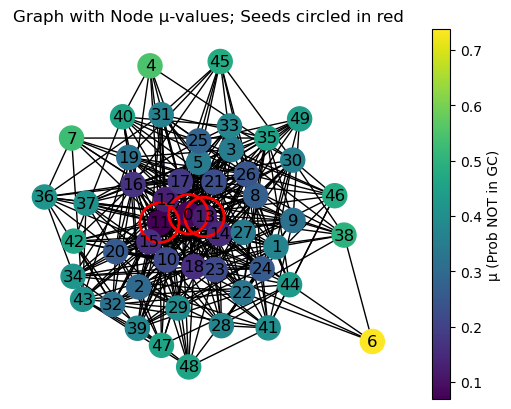

In [25]:

# most bassic approach to pick seeds
# based on the mu values
def pick_seeds_by_mu_1(mu_dict, k):
    """
    Sort nodes by (1 - mu_i) descending, i.e. pick those most likely in GC.
    Return a list of k nodes.
    """
    # Sort by 1 - mu_i descending
    nodes_sorted = sorted(mu_dict.keys(), key=lambda x: (1 - mu_dict[x]), reverse=True)
    return nodes_sorted[:k]



# example visual
def main():
    # similar graph to our results
    G = nx.barabasi_albert_graph(n=50, m=10, seed=42)

    # provs at 0.1
    activation_probabilities = {}
    for u, v in G.edges():
        activation_probabilities[(u, v)] = 0.1
        activation_probabilities[(v, u)] = 0.1

    #Run message passing
    mu_dict = compute_not_in_giant_component_probabilities(G, activation_probabilities)

    # k and thenf find optimal seeds
    k = 3
    seed_nodes = pick_seeds_by_mu_1(mu_dict, k)

    # plot results
    plot_graph(G, mu_values=mu_dict, seed_nodes=seed_nodes)

# run in main function
if __name__ == "__main__":
    main()


## approach 2

In [26]:


def find_large_components(G, mu_values, threshold=0.5):
    """
    Identify connected regions of the graph induced by nodes that are “well-connected”
    (i.e. with (1 - mu_i) above the threshold) and  filter out small regions (min_size).
    """
    # select nodes with (1 - mu) above threshold.
    min_size = max(1, int(0.05 * G.number_of_nodes()))
    selected_nodes = [node for node in G.nodes() if (1 - mu_values[node]) >= threshold]
    subG = G.subgraph(selected_nodes)
    # get connected components
    components = list(nx.connected_components(subG))
    
    # filter out very small components.
    large_components = [comp for comp in components if len(comp) >= min_size]
    return large_components

def pick_seeds_across_components_2(G, mu_values, k, threshold=0.5):
    """
    For more robust seeding, first find connected groups among nodes that are likely in a giant component.
    Then pick the best node (one with highest (1 - mu)) from each region.
    If fewer than k seeds are obtained, fill in the remainder by the global ranking.
    """
    components = find_large_components(G, mu_values, threshold=threshold)
    
    seeds = []
    # pick one seed per identified component
    for comp in components:
        best_node = max(comp, key=lambda node: 1 - mu_values[node])
        seeds.append(best_node)
    
    # if we have fewer than k seeds, fill up with best remaining nodes.
    if len(seeds) < k:
        remaining = sorted(set(G.nodes()) - set(seeds), key=lambda node: 1 - mu_values[node], reverse=True)
        seeds.extend(remaining[:(k - len(seeds))])
    # if we have more than needed, choose the top k by ranking.
    elif len(seeds) > k:
        seeds = sorted(seeds, key=lambda node: 1 - mu_values[node], reverse=True)[:k]
    
    return seeds


## approach 3

In [27]:
# this is a helper function to find all components in the graph
def find_all_components(G):
    """
    Identify ALL connected components of the graph G.
    """
    return list(nx.connected_components(G))


# third appraoch, again component based
def pick_seeds_across_components_3(G, mu_values, k):
    """
    1) Find all connected components in G.
    2) For each component, pick one 'best' node (highest (1 - mu)).
    3) If there are more components than k, pick the top k among them.
    4) If there are fewer components than k, fill the remainder by global ranking.
    """
    # get components
    components = find_all_components(G)
    
    #for each component, pick the single best node by prob in connected comp
    comp_best_nodes = []
    for comp in components:
        best_node = max(comp, key=lambda node: (1 - mu_values[node]))
        best_score = (1 - mu_values[best_node])
        comp_best_nodes.append((comp, best_node, best_score))
    
    #sort the components by their best node’s score 
    comp_best_nodes.sort(key=lambda x: x[2], reverse=True)
    
    # If we have more components than k, keep only top k of them.
    if len(comp_best_nodes) > k:
        comp_best_nodes = comp_best_nodes[:k]
    
    # get the chosen seeds so far.
    seeds = [tpl[1] for tpl in comp_best_nodes]
    
    # iff we have fewer components than k, fill the remainder by global ranking.
    if len(seeds) < k:
        used_nodes = set(seeds)
        # Sort all leftover nodes by (1 - mu), descending.
        leftover_nodes = sorted(
            set(G.nodes()) - used_nodes,
            key=lambda node: (1 - mu_values[node]),
            reverse=True
        )
        seeds.extend(leftover_nodes[:(k - len(seeds))])
    
    return seeds




## Approch 4

In [28]:

# spectral clustering
def partition_graph_into_k_clusters(G, k):
    """
    Partition any graph G into exactly k clusters using spectral clustering.
    """

    
    #  normalized Laplacian matrix as a dense matrix.
    L = nx.normalized_laplacian_matrix(G).astype(float)
    
    # Alt apprach to help with debugging
    #A = nx.to_scipy_sparse_array(G, format='csr')
    #L = csgraph.laplacian(A, normed=True).astype(float)
    
    # error handling
    with np.errstate(divide="ignore"):
        # Compute the first k eigenvectors (smallest eigenvalues)
        eigenvalues, eigenvectors = eigsh(L, k=k, which='SM')
        
    # use k means to conver this to k clusters 
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(eigenvectors)
    
    # assign each node to its cluster
    clusters = {}
    for node, label in zip(G.nodes(), labels):
        clusters.setdefault(label, set()).add(node)
        
    return list(clusters.values())



# actually run the percolation process and get probs
def compute_percolation_within_clusters(G, activation_probabilities, k):
    """
    
    Partition the graph into k clusters using spectral clustering then 
    For each cluster, run the percolation process to find nodes not in the giant component then 
    Select one seed from each cluster based on local percolation results then
    Adjust the number of seeds to match k if necessary
    """
    # clister
    clusters = partition_graph_into_k_clusters(G, k)
    
    # results
    all_mu_values = {}  
    seeds_percolation = []
    
    # for each cluster, run percolation and select best node
    for cluster in clusters:
        if len(cluster) <= 1:
            if len(cluster) == 1:
                seeds_percolation.append(next(iter(cluster)))
            continue
        
        # Create a subgraph for this cluster
        subG = G.subgraph(cluster).copy()
        
        # run the og percolation within this cluster
        mu_local = compute_not_in_giant_component_probabilities(
            subG, 
            {(i, j): activation_probabilities.get((i, j), 0.5) 
             for i in subG.nodes() for j in subG.neighbors(i)})
        
        # track mu's
        all_mu_values.update(mu_local)
        
        # select the best node from this cluster based on percolation results
        if len(mu_local) > 0:
            best_node = max(subG.nodes(), key=lambda node: (1 - mu_local[node]))
            seeds_percolation.append(best_node)
    
    # get global mu values for potential additional seed selection and additional testing
    global_mu_values = compute_not_in_giant_component_probabilities(
        G, activation_probabilities)
    
    
    # update all_mu_values 
    for node in G.nodes():
        if node not in all_mu_values:
            all_mu_values[node] = global_mu_values[node]
    
    # adjust seeds to match k 
    if len(seeds_percolation) < k:
        # if need more seeds add nodes with highest global influence not already selected
        used = set(seeds_percolation)
        leftover = sorted(
            [node for node in G.nodes() if node not in used],
            key=lambda node: (1 - global_mu_values[node]),
            reverse=True
        )
        seeds_percolation.extend(leftover[:(k - len(seeds_percolation))])
    elif len(seeds_percolation) > k:
        # if o many seeds keep only the k most influential ones based on global values
        seeds_percolation = sorted(
            seeds_percolation, 
            key=lambda node: (1 - global_mu_values[node]), 
            reverse=True
        )[:k]
    
    return all_mu_values, clusters, seeds_percolation

# function to do it all
def select_seeds_spectral_percolation(G, activation_probabilities, k):
    """
        function to select seeds using spectral clustering followed by percolation.
    """
    # run it
    mu_values, clusters, seeds_percolation = compute_percolation_within_clusters(
        G, activation_probabilities, k
    )
    
    #  also compute simple global selection, used in some of my testing
    global_mu_values = compute_not_in_giant_component_probabilities(
        G, activation_probabilities)
    seeds_global = pick_seeds_by_mu_1(global_mu_values, k)
    
    return {
        'mu_values': mu_values,
        'clusters': clusters,
        'seeds_percolation': seeds_percolation,
        'seeds_global': seeds_global
    }




# Heuristcs

In [29]:

def pick_highest_degree_seeds(G, k):
    """Return the top k nodes with the highest degree."""
    sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
    return [node for node, degree in sorted_nodes[:k]]

def pick_central_nodes(G, k):
    """Return the top k nodes based on closeness centrality."""
    centrality = nx.closeness_centrality(G)
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    return [node for node, cent in sorted_nodes[:k]]

def pick_random_seeds(G, k):
    """Return k random seeds from the graph."""
    return random.sample(list(G.nodes()), k)

## Sims



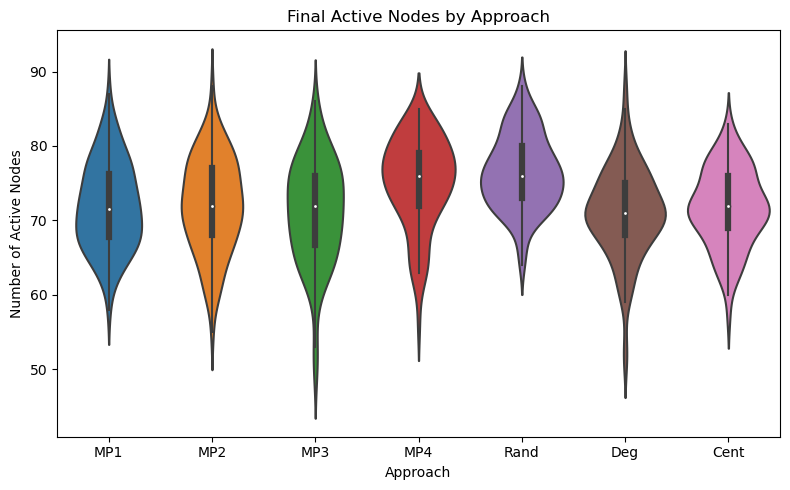

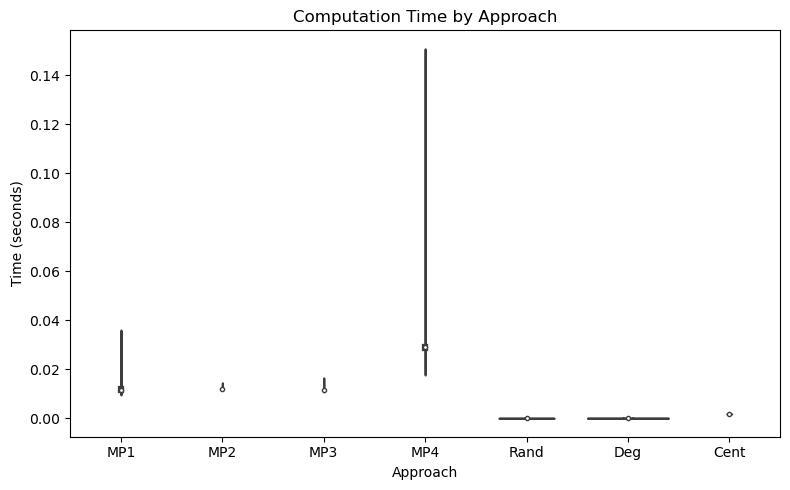

In [30]:
if __name__ == "__main__":
    k=10
    num_simulations = 100
    size=100
    
    #results
    times_mp1 = []
    performance_mp1 = []
    times_mp2 = []
    performance_mp2 = []
    times_mp3 = []
    performance_mp3 = []
    times_mp4 = []
    performance_mp4 = []
    times_deg = []
    performance_deg = []
    times_rand = []
    performance_rand = []
    times_cent = []
    performance_cent = []
    
    
    for i in range(num_simulations):
        G = nx.barabasi_albert_graph(size, 10, seed=42)
        # set at 0.1
        activation_probabilities = {}
        for u, v in G.edges():
            activation_probabilities[(u, v)] = 0.1
            activation_probabilities[(v, u)] = 0.1
    

        # approach 1
        start_time_mp_1 = time.time()
        mu_values_1 = compute_not_in_giant_component_probabilities(G, activation_probabilities)
        mp_seeds_1 = pick_seeds_by_mu_1(mu_values_1, k)
        elapsed_time_mp_1 = time.time() - start_time_mp_1
        final_active_nodes_mp_1 = independent_cascade(G, mp_seeds_1, activation_probabilities)
        # add results
        times_mp1.append(elapsed_time_mp_1)
        performance_mp1.append(len(final_active_nodes_mp_1))
        
        
        # approach 2
        start_time_mp_2 = time.time()
        mu_values_2 = compute_not_in_giant_component_probabilities(G, activation_probabilities)
        mp_seeds_2 = pick_seeds_across_components_2(G, mu_values_2, k)
        elapsed_time_mp_2 = time.time() - start_time_mp_2
        final_active_nodes_mp_2 = independent_cascade(G, mp_seeds_2, activation_probabilities)
        # add results 
        times_mp2.append(elapsed_time_mp_2)
        performance_mp2.append(len(final_active_nodes_mp_2))
        
        
        
        
        
        # approach 3
        start_time_mp_3 = time.time()
        mu_values_3 = compute_not_in_giant_component_probabilities(G, activation_probabilities)
        mp_seeds_3 = pick_seeds_across_components_3(G, mu_values_3, k)
        elapsed_time_mp_3 = time.time() - start_time_mp_3
        final_active_nodes_mp_3 = independent_cascade(G, mp_seeds_3, activation_probabilities)
        # add results
        times_mp3.append(elapsed_time_mp_3)
        performance_mp3.append(len(final_active_nodes_mp_3))
        
        
        
        
        # approach 4
        start_time_mp_4= time.time()
        resulsts_mp4=select_seeds_spectral_percolation(G, activation_probabilities, k)
        seeds_mp_4 = resulsts_mp4['seeds_percolation']
        elapsed_time_mp_4 = time.time() - start_time_mp_4
        final_active_nodes_mp_4 = independent_cascade(G, seeds_mp_4, activation_probabilities)
        # add results: 
        times_mp4.append(elapsed_time_mp_4)
        performance_mp4.append(len(final_active_nodes_mp_4))
        
        
        # random
        start_time_rand = time.time()
        random_seeds = pick_random_seeds(G, k)
        elapsed_time_rand = time.time() - start_time_rand
        final_active_nodes_rand = independent_cascade(G, random_seeds, activation_probabilities)
        times_rand.append(elapsed_time_rand)
        performance_rand.append(len(final_active_nodes_rand))
        
        # degree
        start_time_degree = time.time()
        degree_seeds = pick_highest_degree_seeds(G, k)
        elapsed_time_degree = time.time() - start_time_degree
        final_active_nodes_degree = independent_cascade(G, degree_seeds, activation_probabilities)
        times_deg.append(elapsed_time_degree)
        performance_deg.append(len(final_active_nodes_degree))
        
        # central
        start_time_central = time.time()
        central_seeds = pick_central_nodes(G, k)
        elapsed_time_central = time.time() - start_time_central
        final_active_nodes_central = independent_cascade(G, central_seeds, activation_probabilities)
        times_cent.append(elapsed_time_central)
        performance_cent.append(len(final_active_nodes_central))

    # Prepare performance data for violin plot
    performance_data = {
        "Approach": ["MP1"] * num_simulations + ["MP2"] * num_simulations + 
            ["MP3"] * num_simulations + ["MP4"] * num_simulations +
            ["Rand"] * num_simulations + ["Deg"] * num_simulations + ["Cent"] * num_simulations,
        "Active Nodes": performance_mp1 + performance_mp2+performance_mp3+performance_mp4+performance_rand+performance_deg+performance_cent
    }
    df_perf = pd.DataFrame(performance_data)

    plt.figure(figsize=(8, 5))
    sns.violinplot(x="Approach", y="Active Nodes", data=df_perf, inner="box")
    plt.title("Final Active Nodes by Approach")
    plt.ylabel("Number of Active Nodes")
    plt.xlabel("Approach")
    plt.tight_layout()
    plt.show()
    
    # Prepare time data for violin plot
    time_data = {
    "Approach": ["MP1"] * num_simulations + ["MP2"] * num_simulations+ ["MP3"] * num_simulations + ["MP4"] * num_simulations +["Rand"] * num_simulations+["Deg"] * num_simulations+["Cent"] * num_simulations,
    "Time (s)": times_mp1 + times_mp2+times_mp3+times_mp4+times_rand+times_deg+times_cent
    }
    df_time = pd.DataFrame(time_data)

    plt.figure(figsize=(8, 5))
    sns.violinplot(x="Approach", y="Time (s)", data=df_time, inner="box")
    plt.title("Computation Time by Approach")
    plt.ylabel("Time (seconds)")
    plt.xlabel("Approach")
    plt.tight_layout()
    plt.show()